In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import calendar

# Year used as default for dataset loading and date calculations
YEAR = 2025

# Mapping of month codes to human-readable labels (in Spanish) for reporting
MONTHS = {
    "03": "Marzo de 2025",
    "04": "Abril de 2025",
    "05": "Mayo de 2025",
    "06": "Junio de 2025",
    "07": "Julio de 2025"
}

# Bar colors used consistently in visualizations
BAR_COLORS = {"03": "orange", "04": "purple", "05": "green", "06": "blue", "07": "brown"}

# Default figure size and font size used in plots
DEFAULT_FIGSIZE = (12, 5)
LABEL_FONT_SIZE = 10


# --- Utility Functions ---
def get_days_in_month(month: int, year: int = YEAR) -> int:
    """Return the number of days in a given month."""
    return calendar.monthrange(year, month)[1]

def get_days_metric(df, date_col, guides_df, new_col_name):
    """
    Computes the number of unique days per guide from a given date column.
    Ensures all guides are included, even with 0 days.
    """

    #Count distinct days
    metric = (
        df.groupby("GuideName")[date_col]
        .nunique()
        .reset_index()
        .rename(columns={date_col: new_col_name})
    )

    # Merge with full guide list to include 0s
    full = (
        guides_df[["GuideName"]].drop_duplicates()
        .merge(metric, on="GuideName", how="left")
        .fillna({new_col_name: 0})
    )

    # Convert to int and sort
    full[new_col_name] = full[new_col_name].astype(int)
    return full.sort_values(new_col_name, ascending=False)


def set_guide_plot_labels(ax, title, xlabel, ylabel):
    """Set plot title and axis labels with rotation and tight layout applied."""
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.tight_layout()
    plt.show()


def load_month_data(month: str):
    """Load all datasets for a given month (format '03', '04', etc.)."""
    suffix = f"{month}-{YEAR}"

    data = {
        "bookings": pd.read_csv(f"bookings_{suffix}.csv", parse_dates=["BookingDate"]),
        "tours": pd.read_csv(f"tours_{suffix}.csv"),
        "guides": pd.read_csv(f"guides_{suffix}.csv"),
        "availability": pd.read_csv(
            f"guide_avail_{suffix}.csv", parse_dates=["AvailabilityDate"]
        ),
        "skills": pd.read_csv(f"guide_skills_{suffix}.csv"),
    }

    # Standardize formatting for specific columns across all datasets
    columns_to_standardize = [
        "GuideName",
        "GuideLocation",
        "TimeStart",
        "TimeEnd",
        "TourName",
        "TourLocation",
    ]

    for key in data:
        for column in columns_to_standardize:
            if column in data[key].columns:
                data[key][column] = (
                    data[key][column].astype(str).str.strip("'\" ").str.title()
                )

    return data

In [392]:
# --- Load data for all selected months ---
months = [
    "03",
    "04",
    "05",
    "06",
    "07"
]  # Update this list as new monthly data becomes available
all_data = {m: load_month_data(m) for m in months}

In [393]:
# --- Extract individual datasets by type across all months ---
# This creates separate dictionaries for each dataset type
bookings = {m: all_data[m]["bookings"] for m in months}
tours = {m: all_data[m]["tours"] for m in months}
guides = {m: all_data[m]["guides"] for m in months}
availability = {m: all_data[m]["availability"] for m in months}
skills = {m: all_data[m]["skills"] for m in months}

In [394]:
# Merge bookings with tour details for each month
bookings_tours = {}

for m in MONTHS:
    bookings_tours[m] = bookings[m].merge(
        tours[m], left_on="TourID", right_on="id", how="left"
    )

In [395]:
# Merge bookings+tours data with guide information
# Then rename overlapping 'id' columns to avoid confusion
bookings_merged = {}

for m in MONTHS:
    bookings_merged[m] = bookings_tours[m].merge(
        guides[m], left_on="GuideID", right_on="id", how="left"
    )

# Rename columns if merge introduced ambiguous 'id_x' and 'id_y'
for m in MONTHS:
    df = bookings_merged[m]
    rename_cols = {}
    if "id_x" in df.columns:
        rename_cols["id_x"] = "TourID_Source"
    if "id_y" in df.columns:
        rename_cols["id_y"] = "GuideID_Source"
    if rename_cols:
        bookings_merged[m] = df.rename(columns=rename_cols)

In [396]:
# Merge guide skill data with guide information
skills_named = {}

for m in MONTHS:
    skills_named[m] = skills[m].merge(
        guides[m], left_on="GuideID", right_on="id", how="left"
    )

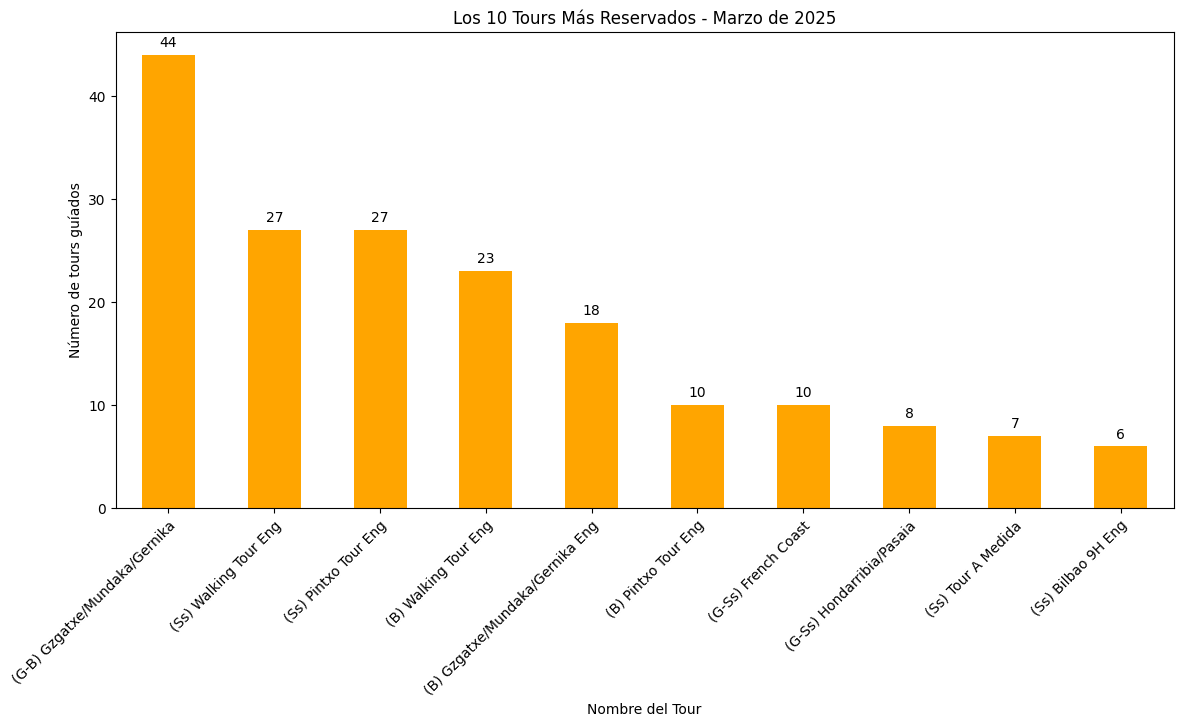

In [397]:
# --- INSIGHT 1.1: Top 10 most booked tours in March 2025 ---

for m in ["03"]:
    # Extract the top 10 most booked tour names for the selected month
    top_tours = bookings_tours[m]["TourName"].value_counts().head(10)

    # Plot a bar chart for the top 10 tours
    ax = top_tours.plot(kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["03"])

    # Add value labels above each bar
    for i, value in enumerate(top_tours.values):
        ax.text(
            i,
            value + 0.5,
            str(value),
            ha="center",
            va="bottom",
            fontsize=LABEL_FONT_SIZE,
        )

# Set title and axis labels (Spanish labels as per data context)
ax.set_title(f'Los 10 Tours Más Reservados - {MONTHS["03"]}')
ax.set_xlabel("Nombre del Tour")
ax.set_ylabel("Número de tours guíados")

# Improve layout and spacing
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)  # reduce the value to create more space above
plt.show()

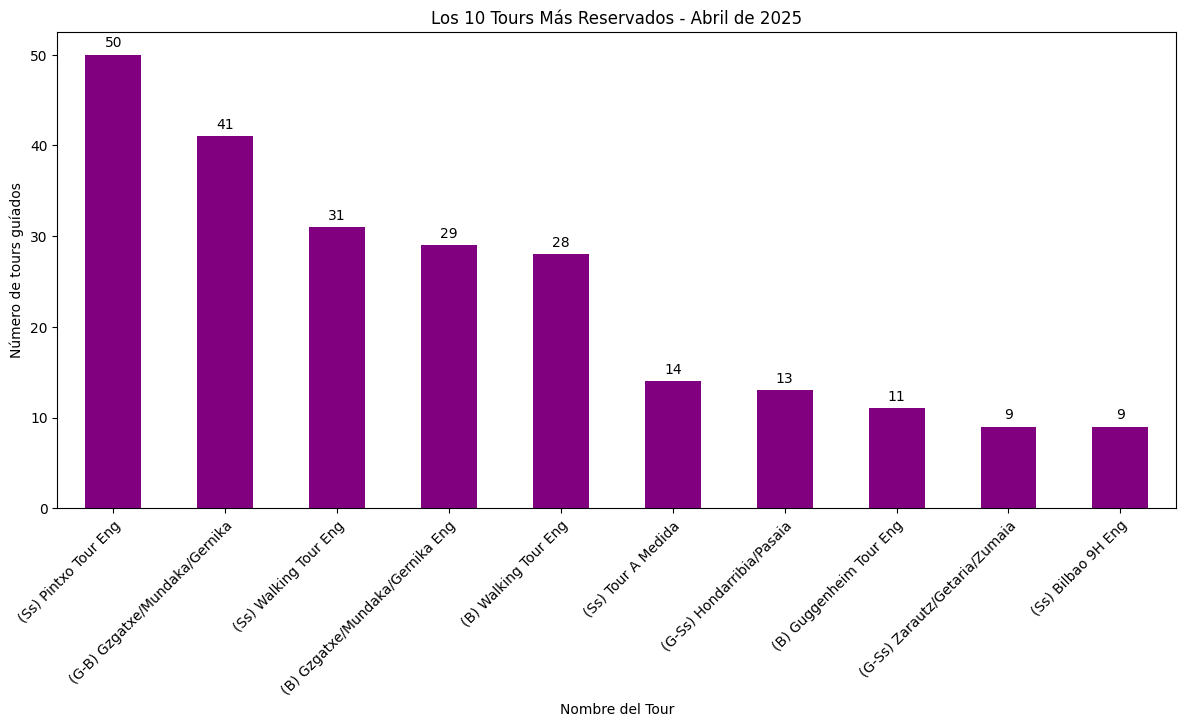

In [398]:
# --- INSIGHT 1.2: Top 10 Tours for April 2025 ---

for m in ["04"]:
    # Extract the top 10 most booked tour names for the selected month
    top_tours = bookings_tours[m]["TourName"].value_counts().head(10)

    # Create a bar chart of the top 10 tours
    ax = top_tours.plot(kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["04"])

    # Add value labels above the bars
    for i, value in enumerate(top_tours.values):
        ax.text(
            i,
            value + 0.5,
            str(value),
            ha="center",
            va="bottom",
            fontsize=LABEL_FONT_SIZE,
        )

# Apply titles and labels
ax.set_title(f'Los 10 Tours Más Reservados - {MONTHS["04"]}')
ax.set_xlabel("Nombre del Tour")
ax.set_ylabel("Número de tours guíados")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

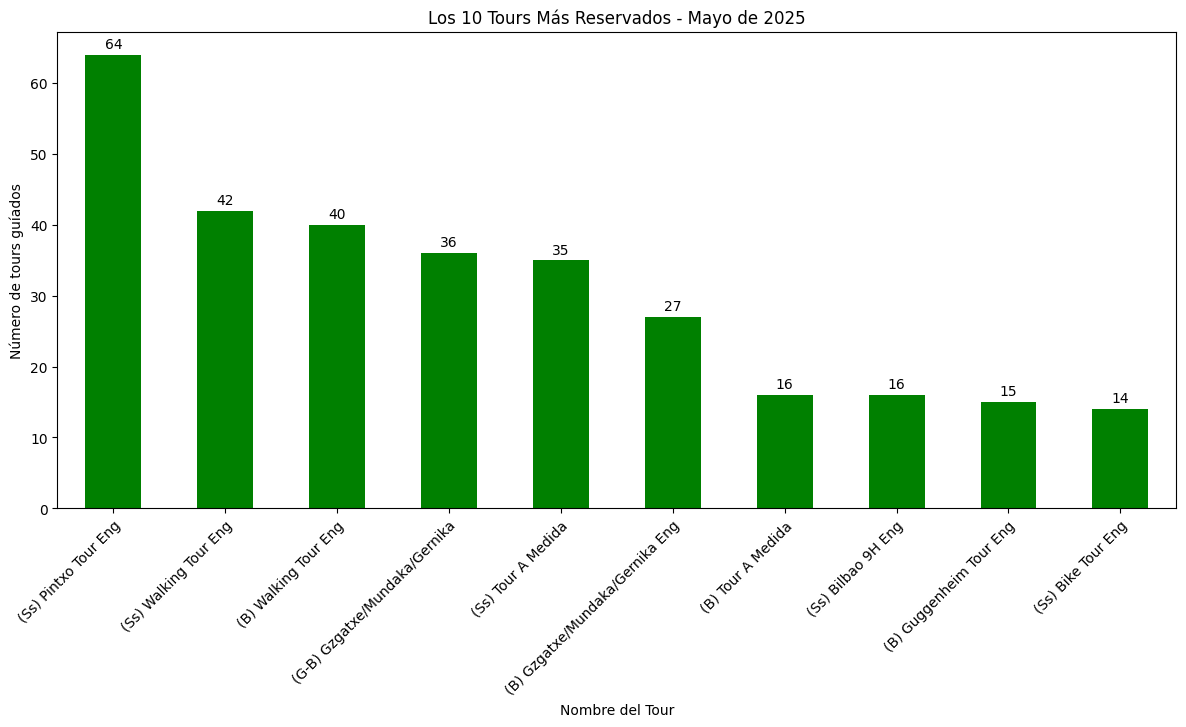

In [399]:
# --- INSIGHT 1.3: Top 10 Tours for May 2025 ---

for m in ["05"]:
    # Extract the top 10 most booked tour names for the selected month
    top_tours = bookings_tours[m]["TourName"].value_counts().head(10)

    # Create a bar chart of the top 10 tours
    ax = top_tours.plot(kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["05"])

    # Add value labels above the bars
    for i, value in enumerate(top_tours.values):
        ax.text(
            i,
            value + 0.5,
            str(value),
            ha="center",
            va="bottom",
            fontsize=LABEL_FONT_SIZE,
        )

# Apply titles and labels
ax.set_title(f'Los 10 Tours Más Reservados - {MONTHS["05"]}')
ax.set_xlabel("Nombre del Tour")
ax.set_ylabel("Número de tours guíados")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

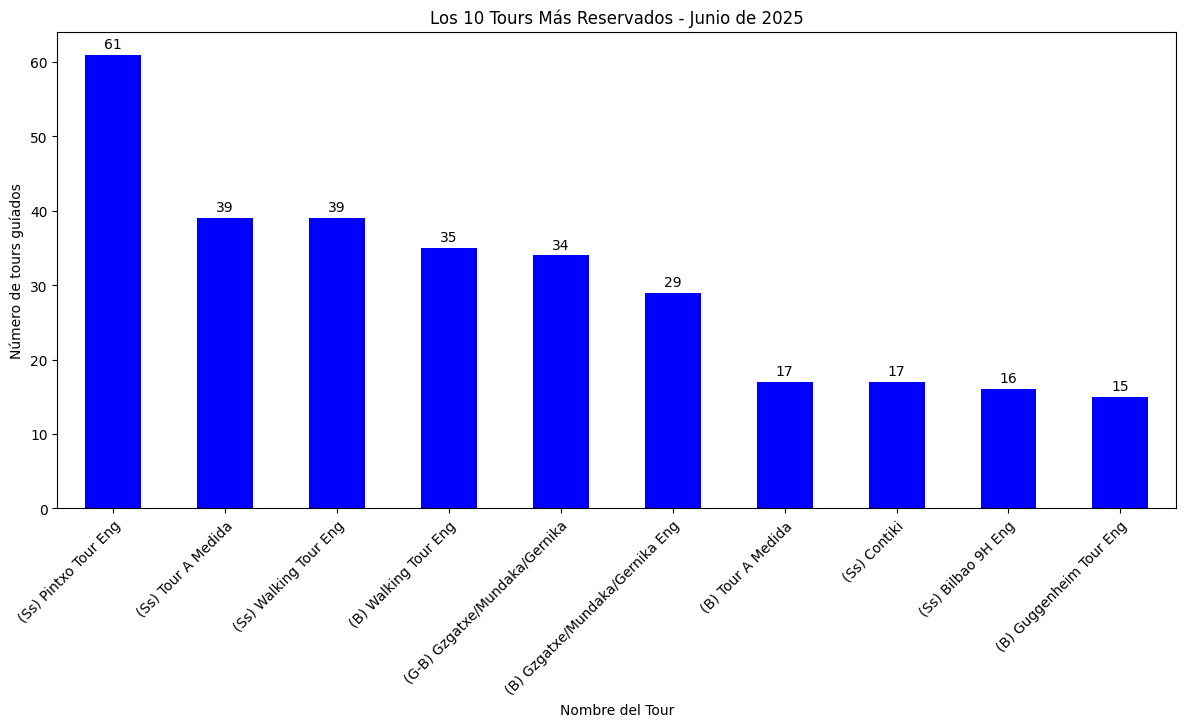

In [400]:
# --- INSIGHT 1.4: Top 10 Tours for June 2025 ---

for m in ["06"]:
    # Extract the top 10 most booked tour names for the selected month
    top_tours = bookings_tours[m]["TourName"].value_counts().head(10)

    # Create a bar chart of the top 10 tours
    ax = top_tours.plot(kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["06"])

    # Add value labels above the bars
    for i, value in enumerate(top_tours.values):
        ax.text(
            i,
            value + 0.5,
            str(value),
            ha="center",
            va="bottom",
            fontsize=LABEL_FONT_SIZE,
        )

# Apply titles and labels
ax.set_title(f'Los 10 Tours Más Reservados - {MONTHS["06"]}')
ax.set_xlabel("Nombre del Tour")
ax.set_ylabel("Número de tours guíados")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

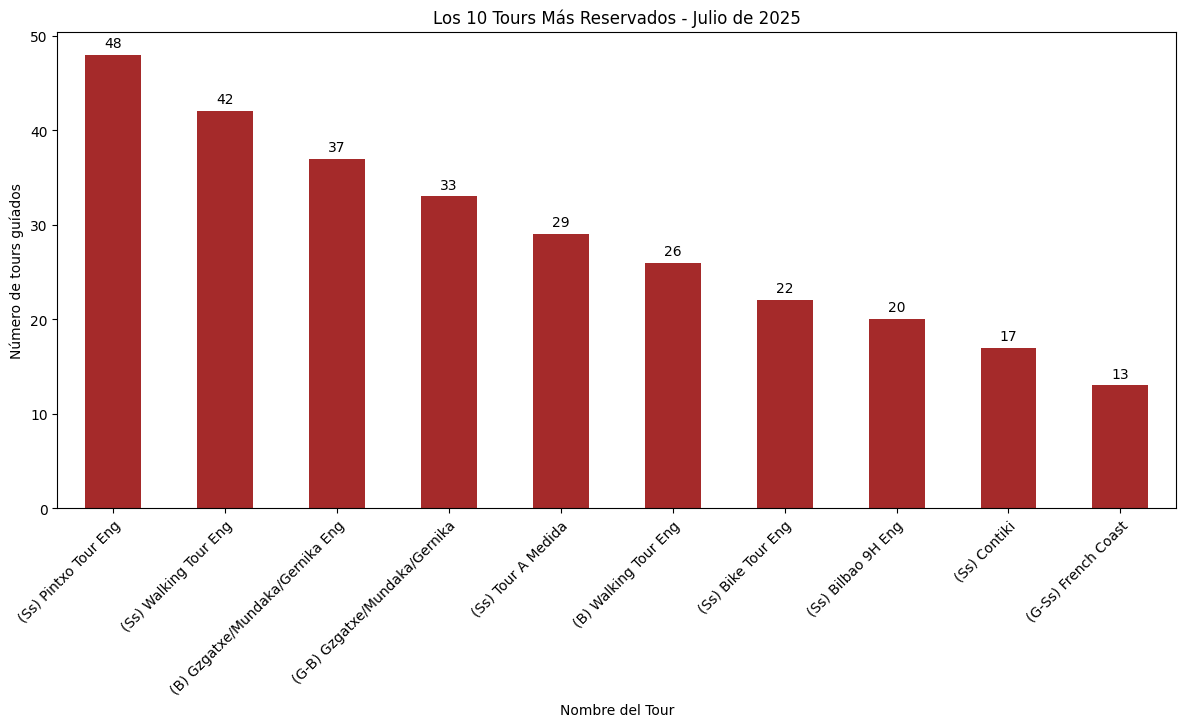

In [401]:
# --- INSIGHT 1.5: Top 10 Tours for July 2025 ---

for m in ["07"]:
    # Extract the top 10 most booked tour names for the selected month
    top_tours = bookings_tours[m]["TourName"].value_counts().head(10)

    # Create a bar chart of the top 10 tours
    ax = top_tours.plot(kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["07"])

    # Add value labels above the bars
    for i, value in enumerate(top_tours.values):
        ax.text(
            i,
            value + 0.5,
            str(value),
            ha="center",
            va="bottom",
            fontsize=LABEL_FONT_SIZE,
        )

# Apply titles and labels
ax.set_title(f'Los 10 Tours Más Reservados - {MONTHS["07"]}')
ax.set_xlabel("Nombre del Tour")
ax.set_ylabel("Número de tours guíados")

# Rotate x-axis labels and adjust layout
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

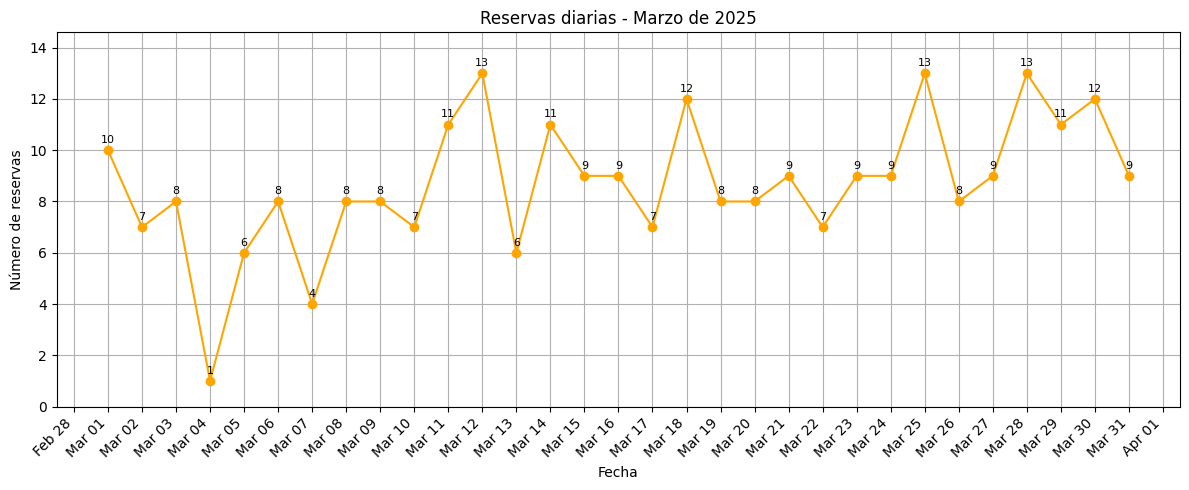

In [402]:

# --- INSIGHT 2.1: Peak Booking Dates in March 2025 ---

for m in ["03"]:  # Loop through selected months
    month_name = calendar.month_name[int(m)]  # e.g., "March"

    # Get number of bookings per date, sorted chronologically
    daily_bookings = bookings[m]["BookingDate"].value_counts().sort_index()

    # Plot daily bookings as a line chart
    plt.figure(figsize=DEFAULT_FIGSIZE)
    plt.plot(
        daily_bookings.index, daily_bookings.values, marker="o", color=BAR_COLORS[m]
    )

    # Add value labels to each point
    for x, y in zip(daily_bookings.index, daily_bookings.values):
        plt.text(
            x, y + 0.2, str(y), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE - 2
        )

# Apply title and axis labels
plt.title(f'Reservas diarias - {MONTHS["03"]}')
plt.xlabel("Fecha")  # EN: Date
plt.ylabel("Número de reservas")  # EN: Number of Bookings
plt.grid(True)

# Format x-axis to show daily ticks and readable date labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add headroom to y-axis
ax = plt.gca()
current_ylim = ax.get_ylim()
ax.set_ylim(0, current_ylim[1] + 1)

plt.show()

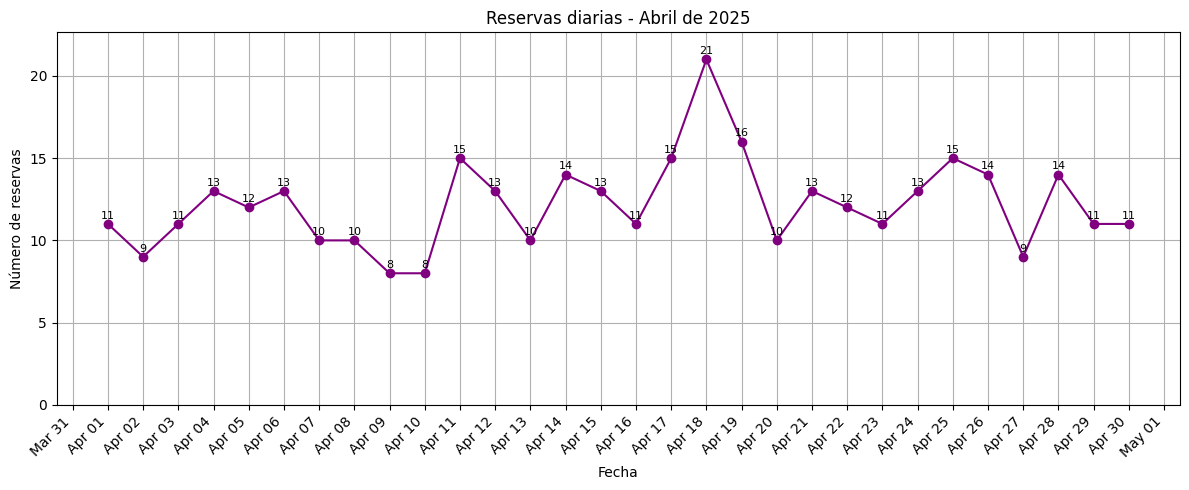

In [403]:
# --- INSIGHT 2.2: Peak Booking Dates in April 2025 ---

for m in ["04"]:  # Loop through selected months
    month_name = calendar.month_name[int(m)]  # e.g., "April"
    mm_yy_of_reference = f"{month_name} de {YEAR}"

    # Count number of bookings per date, sorted chronologically
    daily_bookings = bookings[m]["BookingDate"].value_counts().sort_index()

    # Plot daily bookings as a line chart
    plt.figure(figsize=DEFAULT_FIGSIZE)
    plt.plot(
        daily_bookings.index, daily_bookings.values, marker="o", color=BAR_COLORS["04"]
    )

    # Add value labels to each point
    for x, y in zip(daily_bookings.index, daily_bookings.values):
        plt.text(
            x, y + 0.2, str(y), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE - 2
        )

# Apply title and axis labels
plt.title(f'Reservas diarias - {MONTHS["04"]}')
plt.xlabel("Fecha")  # EN: Date
plt.ylabel("Número de reservas")  # EN: Number of Bookings
plt.grid(True)

# Format x-axis as daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add headroom to y-axis
ax = plt.gca()
current_ylim = ax.get_ylim()
ax.set_ylim(0, current_ylim[1] + 1)

plt.show()

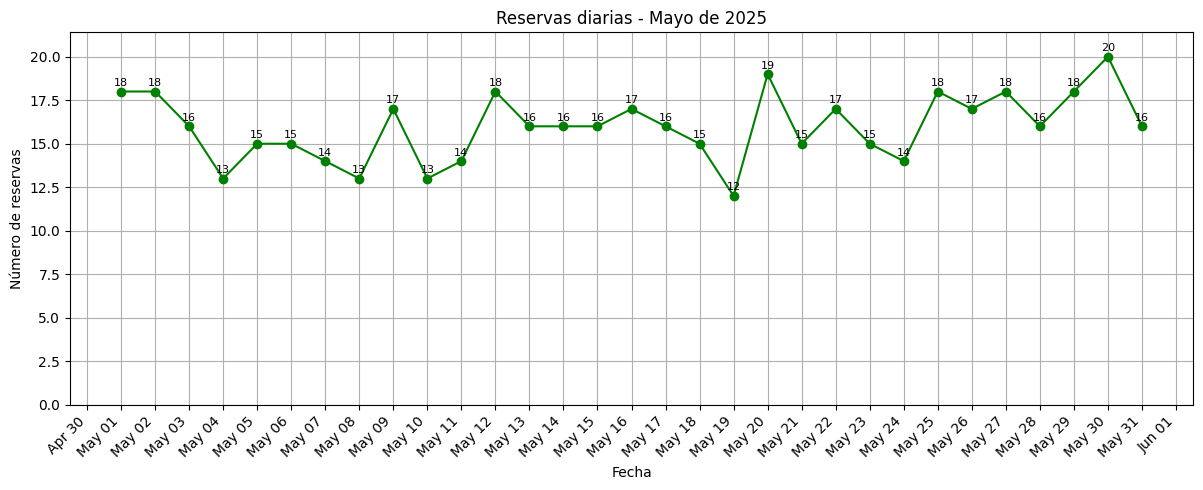

In [404]:
# --- INSIGHT 2.3: Peak Booking Dates in May 2025 ---

for m in ["05"]:  # Loop through selected months
    month_name = calendar.month_name[int(m)]  # e.g., "May"

    # Count number of bookings per date, sorted chronologically
    daily_bookings = bookings[m]["BookingDate"].value_counts().sort_index()

    # Plot daily bookings as a line chart
    plt.figure(figsize=DEFAULT_FIGSIZE)
    plt.plot(
        daily_bookings.index, daily_bookings.values, marker="o", color=BAR_COLORS["05"]
    )

    # Add value labels to each point
    for x, y in zip(daily_bookings.index, daily_bookings.values):
        plt.text(
            x, y + 0.2, str(y), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE - 2
        )

# Apply title and axis labels
plt.title(f'Reservas diarias - {MONTHS["05"]}')
plt.xlabel("Fecha")  # EN: Date
plt.ylabel("Número de reservas")  # EN: Number of Bookings
plt.grid(True)

# Format x-axis as daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add headroom to y-axis
ax = plt.gca()
current_ylim = ax.get_ylim()
ax.set_ylim(0, current_ylim[1] + 1)

plt.show()

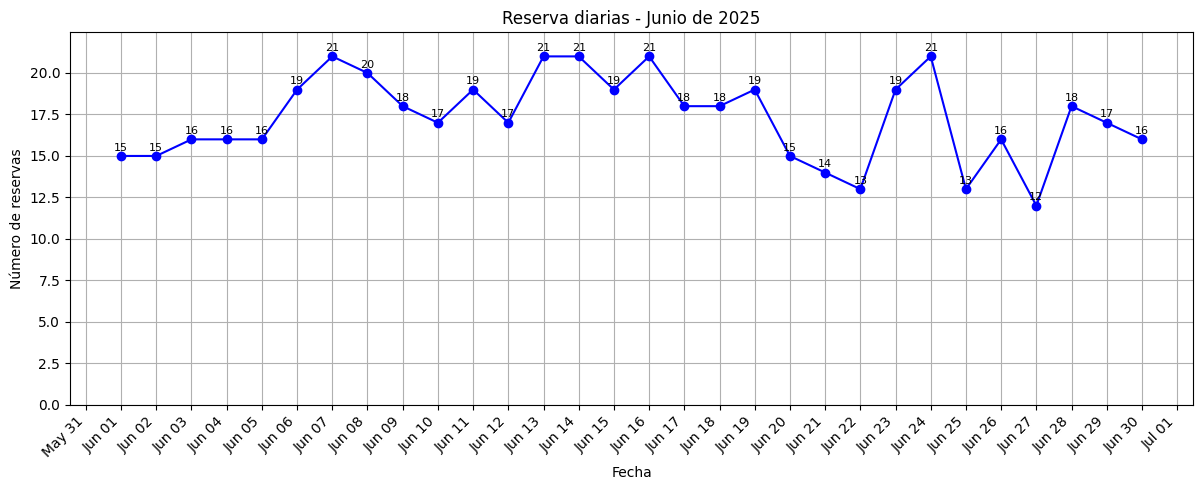

In [405]:
# --- INSIGHT 2.4: Peak Booking Dates in June 2025 ---

for m in ["06"]:  # Loop through selected months
    month_name = calendar.month_name[int(m)]  # e.g., "June"

    # Count number of bookings per date, sorted chronologically
    daily_bookings = bookings[m]["BookingDate"].value_counts().sort_index()

    # Plot daily bookings as a line chart
    plt.figure(figsize=DEFAULT_FIGSIZE)
    plt.plot(
        daily_bookings.index, daily_bookings.values, marker="o", color=BAR_COLORS["06"]
    )

    # Add value labels to each point
    for x, y in zip(daily_bookings.index, daily_bookings.values):
        plt.text(
            x, y + 0.2, str(y), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE - 2
        )

# Apply title and axis labels
plt.title(f'Reserva diarias - {MONTHS["06"]}')
plt.xlabel("Fecha")  # EN: Date
plt.ylabel("Número de reservas")  # EN: Number of Bookings
plt.grid(True)

# Format x-axis as daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add headroom to y-axis
ax = plt.gca()
current_ylim = ax.get_ylim()
ax.set_ylim(0, current_ylim[1] + 1)

plt.show()

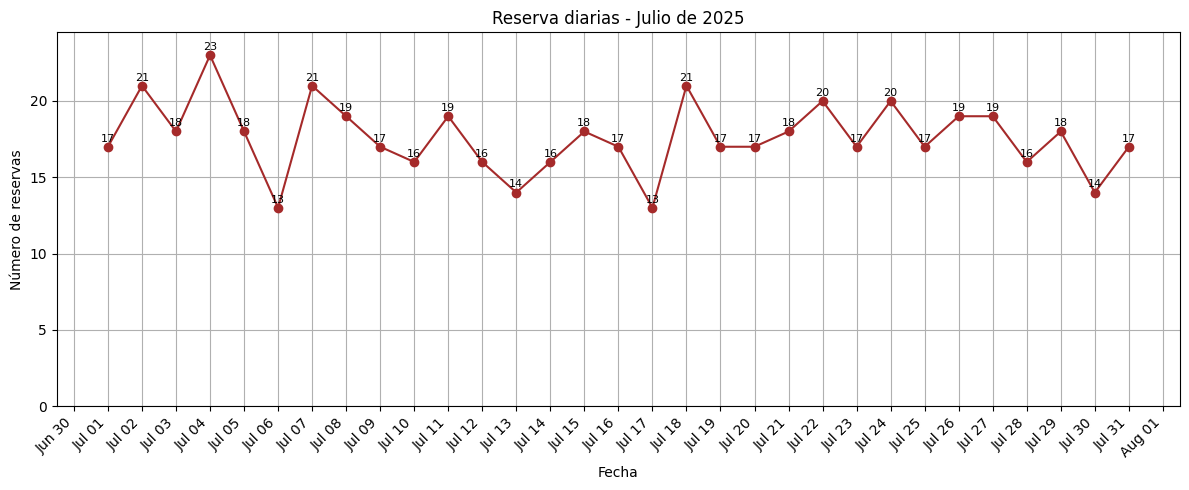

In [406]:
# --- INSIGHT 2.5: Peak Booking Dates in July 2025 ---

for m in ["07"]:  # Loop through selected months
    month_name = calendar.month_name[int(m)]  # e.g., "July"

    # Count number of bookings per date, sorted chronologically
    daily_bookings = bookings[m]["BookingDate"].value_counts().sort_index()

    # Plot daily bookings as a line chart
    plt.figure(figsize=DEFAULT_FIGSIZE)
    plt.plot(
        daily_bookings.index, daily_bookings.values, marker="o", color=BAR_COLORS["07"]
    )

    # Add value labels to each point
    for x, y in zip(daily_bookings.index, daily_bookings.values):
        plt.text(
            x, y + 0.2, str(y), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE - 2
        )

# Apply title and axis labels
plt.title(f'Reserva diarias - {MONTHS["07"]}')
plt.xlabel("Fecha")  # EN: Date
plt.ylabel("Número de reservas")  # EN: Number of Bookings
plt.grid(True)

# Format x-axis as daily ticks
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add headroom to y-axis
ax = plt.gca()
current_ylim = ax.get_ylim()
ax.set_ylim(0, current_ylim[1] + 1)

plt.show()

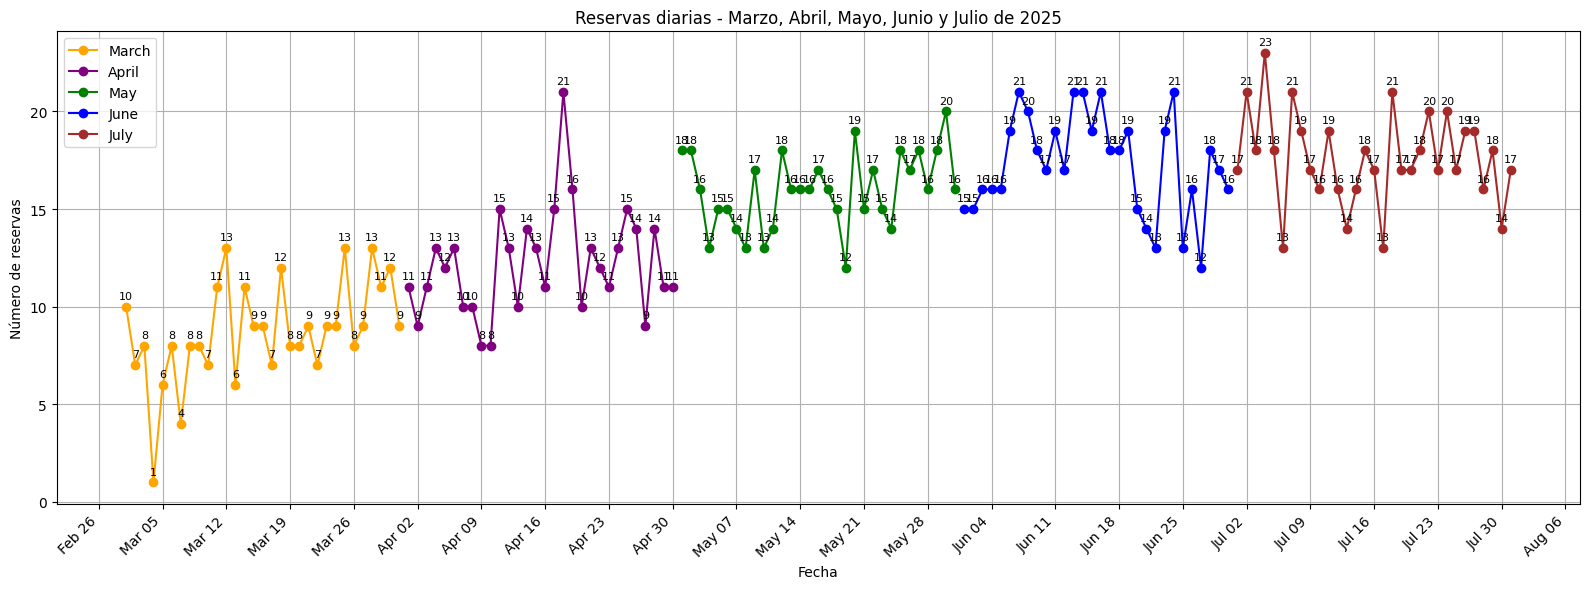

In [407]:
# --- INSIGHT 2.6: Compare daily bookings across March–July 2025 on a single plot ---

# Set title for combined months (in Spanish)
mm_yy_of_reference = "Marzo, Abril, Mayo, Junio y Julio de 2025"

# Prepare data for selected months
combined_daily_bookings = {}

for m in ["03", "04", "05", "06", "07"]:
    daily_counts = bookings[m]["BookingDate"].value_counts().sort_index()
    combined_daily_bookings[m] = daily_counts

# Plot daily bookings for each month on the same axes
plt.figure(figsize=(16, 6))
plt.subplots_adjust(top=0.88, bottom=0.15)

for m, daily_data in combined_daily_bookings.items():
    plt.plot(
        daily_data.index,
        daily_data.values,
        marker="o",
        label=calendar.month_name[int(m)],
        color=BAR_COLORS[m],
    )

    # Add value labels to each point
    for x, y in zip(daily_data.index, daily_data.values):
        plt.text(
            x, y + 0.3, str(y), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE - 2
        )

# Set labels and title
plt.title(f"Reservas diarias - {mm_yy_of_reference}")
plt.xlabel("Fecha")  # EN : Date
plt.ylabel("Número de reservas")  # EN: Number of Bookings
plt.grid(True)

# Format x-axis ticks for weekly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45, ha="right")

# Add legend
plt.legend()
plt.tight_layout()
plt.show()

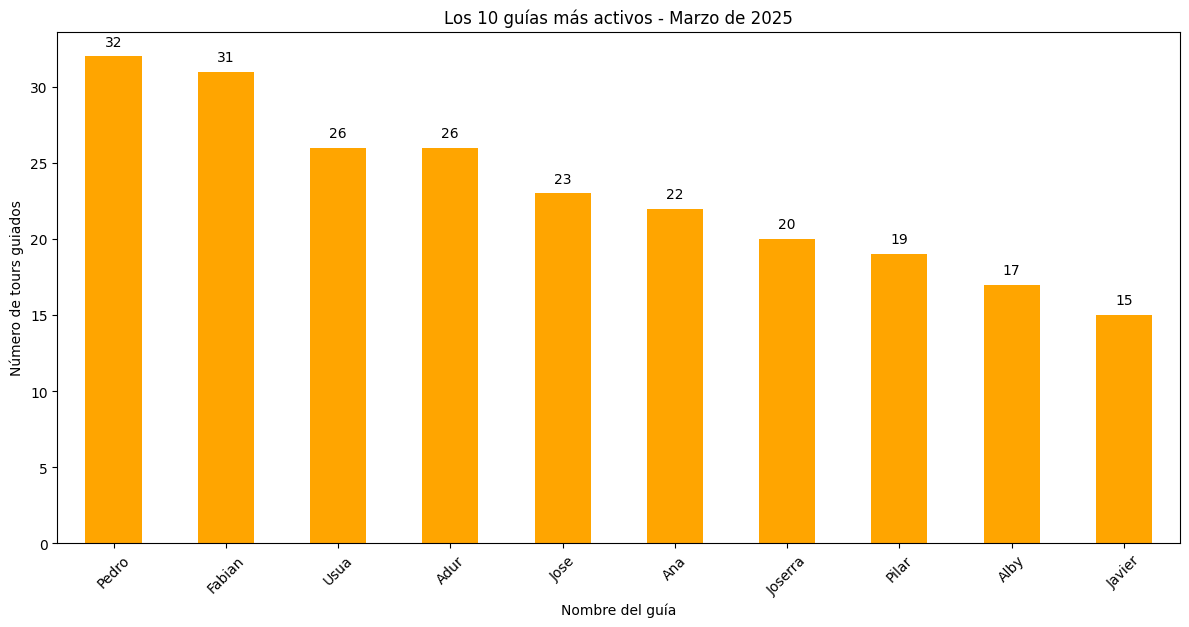

In [408]:
# --- INSIGHT 3.1: Most Active Guides by Name for March 2025 ---

# Extract the 10 most active guides (by number of tours led)
top_guides_03_2025 = bookings_merged["03"]["GuideName"].value_counts().head(10)

# Plot the top 10 guide names
ax = top_guides_03_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["03"]
)

# Add value labels on top of each bar
for i, value in enumerate(top_guides_03_2025.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set axis titles and styling
ax.set_title(
    f'Los 10 guías más activos - {MONTHS["03"]}'
)  # EN: The 10 Most Active Guides
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de tours guiados")  # EN: Number of Tours Guided
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(top=1.2)  # Adjust vertical spacing
plt.show()

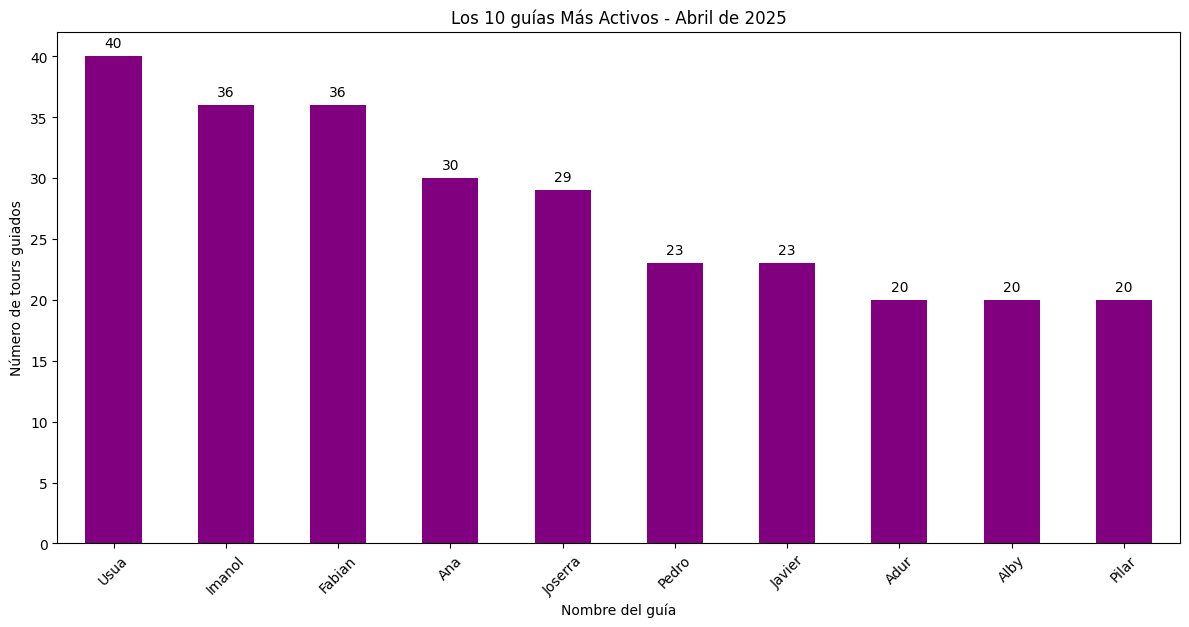

In [409]:
# --- INSIGHT 3.2: Most Active Guides by Name for April 2025 ---

# Extract the 10 most active guides (by number of tours led)
top_guides_04_2025 = bookings_merged["04"]["GuideName"].value_counts().head(10)

# Plot the top 10 guide names
ax = top_guides_04_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["04"]
)

# Add value labels on top of each bar
for i, value in enumerate(top_guides_04_2025.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set axis titles and styling
ax.set_title(
    f'Los 10 guías Más Activos - {MONTHS["04"]}'
)  # EN: The 10 Most Active Guides
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de tours guiados")  # EN: Number of Tours Guided
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(top=1.2)  # Adjust vertical spacing
plt.show()

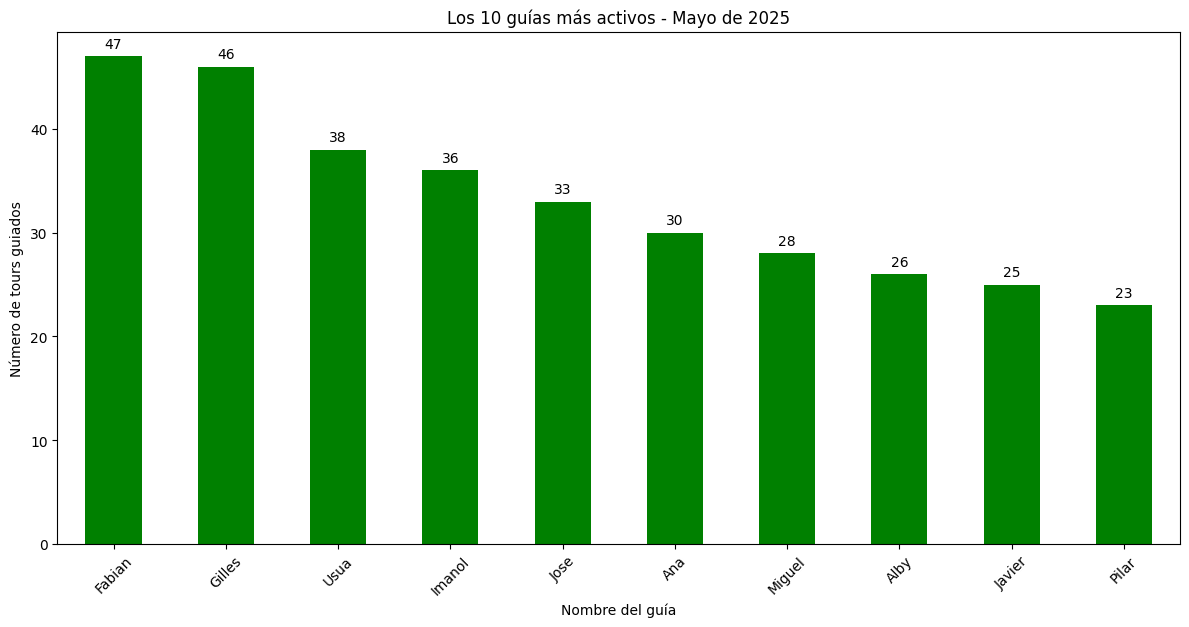

In [410]:
# --- INSIGHT 3.3: Most Active Guides by Name for May 2025 ---

# Extract the 10 most active guides (by number of tours led)
top_guides_05_2025 = bookings_merged["05"]["GuideName"].value_counts().head(10)

# Plot the top 10 guide names
ax = top_guides_05_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["05"]
)

# Add value labels on top of each bar
for i, value in enumerate(top_guides_05_2025.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set axis titles and styling
ax.set_title(
    f'Los 10 guías más activos - {MONTHS["05"]}'
)  # EN: The 10 Most Active Guides
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de tours guiados")  # EN: Number of Tours Guided
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(top=1.2)  # Adjust vertical spacing
plt.show()

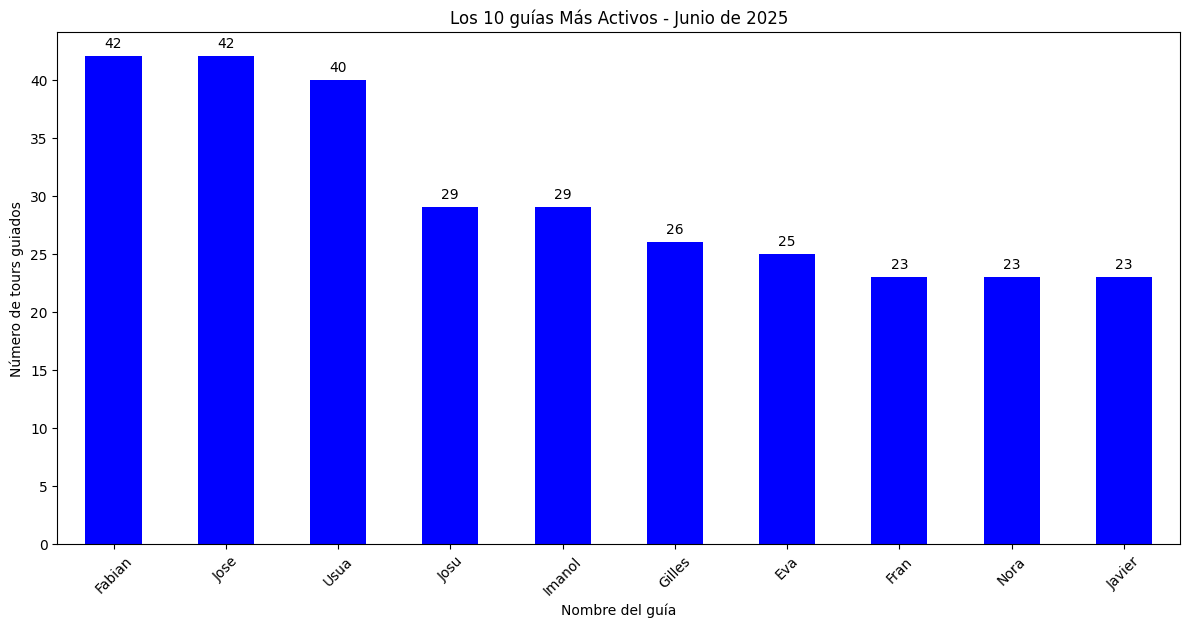

In [411]:
# --- INSIGHT 3.4: Most Active Guides by Name for June 2025 ---

# Extract the 10 most active guides (by number of tours led)
top_guides_06_2025 = bookings_merged["06"]["GuideName"].value_counts().head(10)

# Plot the top 10 guide names
ax = top_guides_06_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["06"]
)

# Add value labels on top of each bar
for i, value in enumerate(top_guides_06_2025.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set axis titles and styling
ax.set_title(
    f'Los 10 guías Más Activos - {MONTHS["06"]}'
)  # EN: The 10 Most Active Guides
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de tours guiados")  # EN: Number of Tours Guided
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(top=1.2)  # Adjust vertical spacing
plt.show()

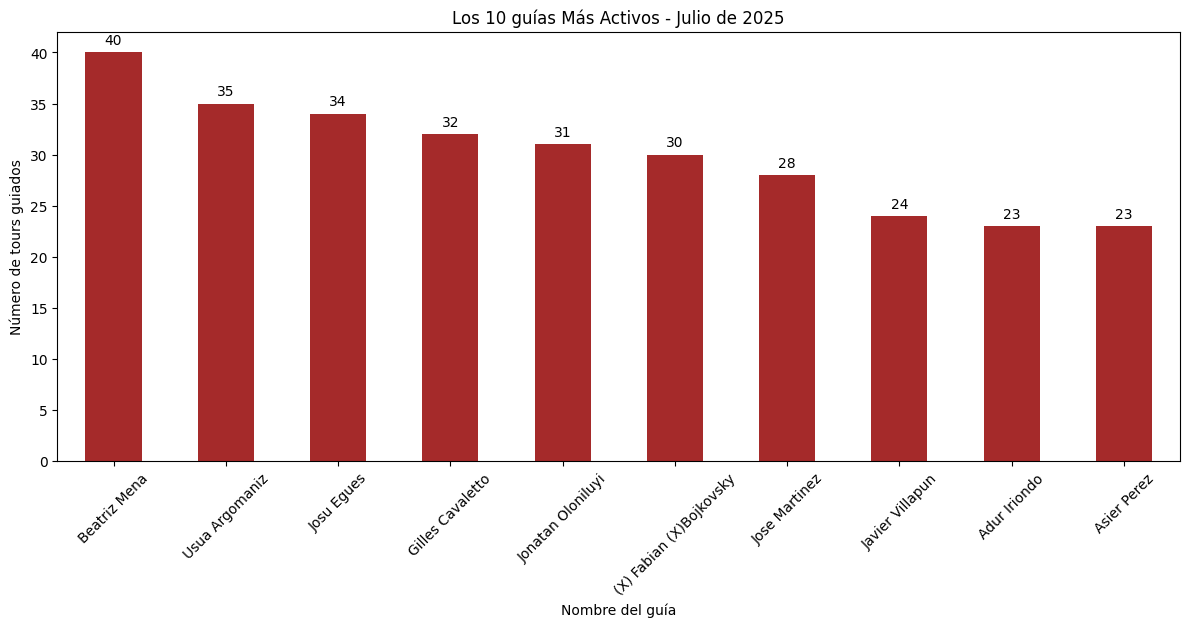

In [412]:
# --- INSIGHT 3.5: Most Active Guides by Name for July 2025 ---

# Extract the 10 most active guides (by number of tours led)
top_guides_07_2025 = bookings_merged["07"]["GuideName"].value_counts().head(10)

# Plot the top 10 guide names
ax = top_guides_07_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["07"]
)

# Add value labels on top of each bar
for i, value in enumerate(top_guides_07_2025.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set axis titles and styling
ax.set_title(
    f'Los 10 guías Más Activos - {MONTHS["07"]}'
)  # EN: The 10 Most Active Guides
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de tours guiados")  # EN: Number of Tours Guided
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(top=1.2)  # Adjust vertical spacing
plt.show()

In [413]:
# --- INSIGHT 4.0: Guides with the most availability days ---
# An "availability day" is defined as any day where a guide has at least one available time slot.
# The goal is to find which guides are available the most across each month.

# Step: Merge guides with their availability to get guide names into availability records
availability_days_guides = {}  # initialize the dictionary before using it

for m in MONTHS:
    availability_days_guides[m] = guides[m].merge(
        availability[m], left_on="id", right_on="GuideID", how="left"
    )

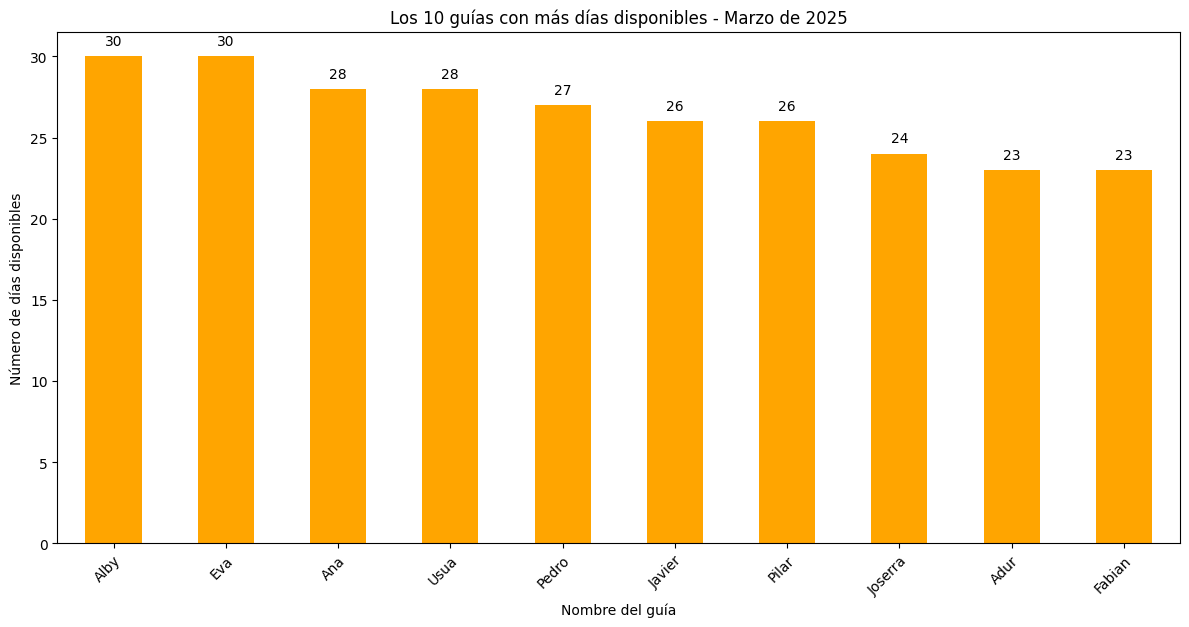

In [414]:
# --- INSIGHT 4.1: Guides with the most availability days for March 2025 ---
# An availability day is any day a guide has at least one available time slot.

# Filter availability records for March 2025
availability_data_03 = availability_days_guides["03"]

# Keep only records where GuideAvailability is present and non-empty
valid_avail_03 = availability_data_03[
    availability_data_03["GuideAvailability"].notna()
    & (availability_data_03["GuideAvailability"] != "")
]

# Count number of distinct available days per guide
available_days_per_guide_03 = (
    valid_avail_03.groupby("GuideName")["AvailabilityDate"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the top 10 most available guides
ax = available_days_per_guide_03.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["03"]
)

# Add value labels above each bar
for i, value in enumerate(available_days_per_guide_03.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Los 10 guías con más días disponibles - {MONTHS["03"]}'
)  # EN: Top 10 Guides with Most Available Days (March 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

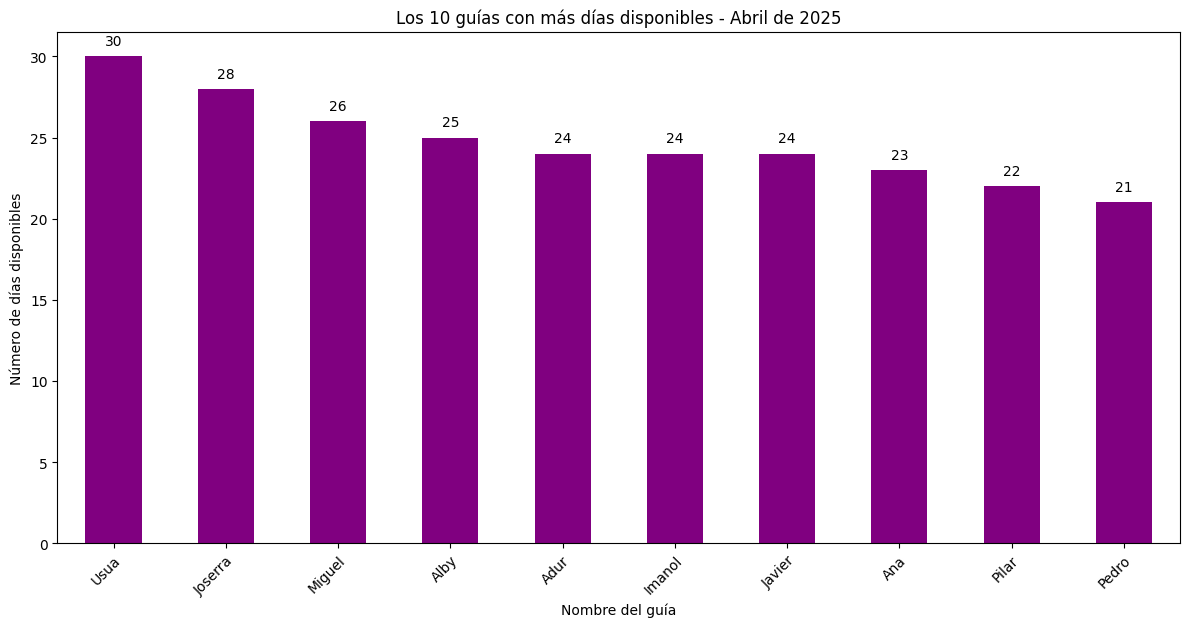

In [415]:
# --- INSIGHT 4.2: Guides with the most availability days for April 2025 ---
# An availability day is any day a guide has at least one available time slot.

# Filter availability records for April 2025
availability_data_04 = availability_days_guides["04"]

# Keep only records where GuideAvailability is present and non-empty
valid_avail_04 = availability_data_04[
    availability_data_04["GuideAvailability"].notna()
    & (availability_data_04["GuideAvailability"] != "")
]

# Count number of distinct available days per guide
available_days_per_guide_04 = (
    valid_avail_04.groupby("GuideName")["AvailabilityDate"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the top 10 most available guides
ax = available_days_per_guide_04.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["04"]
)

# Add value labels above each bar
for i, value in enumerate(available_days_per_guide_04.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and labels
ax.set_title(
    f'Los 10 guías con más días disponibles - {MONTHS["04"]}'
)  # EN: Top 10 Guides with Most Available Days (April 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

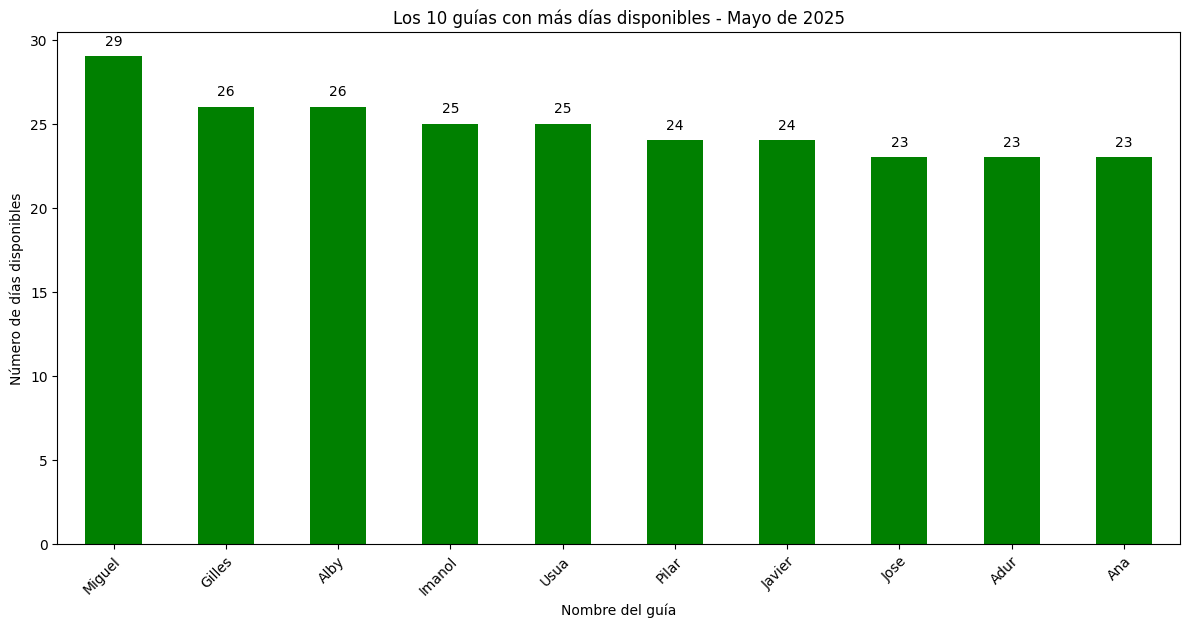

In [416]:
# --- INSIGHT 4.3: Guides with the most availability days for May 2025 ---
# An availability day is any day a guide has at least one available time slot.

# Filter availability records for May 2025
availability_data_05 = availability_days_guides["05"]

# Keep only records where GuideAvailability is present and non-empty
valid_avail_05 = availability_data_05[
    availability_data_05["GuideAvailability"].notna()
    & (availability_data_05["GuideAvailability"] != "")
]

# Count number of distinct available days per guide
available_days_per_guide_05 = (
    valid_avail_05.groupby("GuideName")["AvailabilityDate"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the top 10 most available guides
ax = available_days_per_guide_05.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["05"]
)

# Add value labels above each bar
for i, value in enumerate(available_days_per_guide_05.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Los 10 guías con más días disponibles - {MONTHS["05"]}'
)  # EN: Top 10 Guides with Most Available Days (May 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

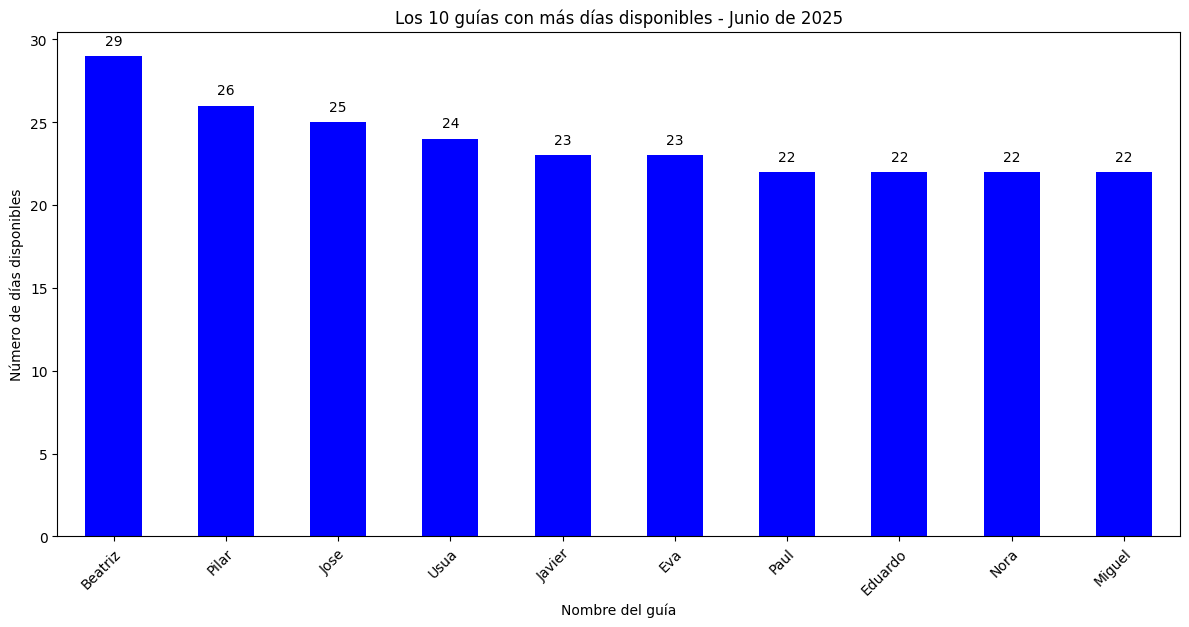

In [417]:
# --- INSIGHT 4.4: Guides with the most availability days for June 2025 ---
# An availability day is any day a guide has at least one available time slot.

# Filter availability records for June 2025
availability_data_06 = availability_days_guides["06"]

# Keep only records where GuideAvailability is present and non-empty
valid_avail_06 = availability_data_06[
    availability_data_06["GuideAvailability"].notna()
    & (availability_data_06["GuideAvailability"] != "")
]

# Count number of distinct available days per guide
available_days_per_guide_06 = (
    valid_avail_06.groupby("GuideName")["AvailabilityDate"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the top 10 most available guides
ax = available_days_per_guide_06.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["06"]
)

# Add value labels above each bar
for i, value in enumerate(available_days_per_guide_06.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Los 10 guías con más días disponibles - {MONTHS["06"]}'
)  # EN: Top 10 Guides with Most Available Days (June 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

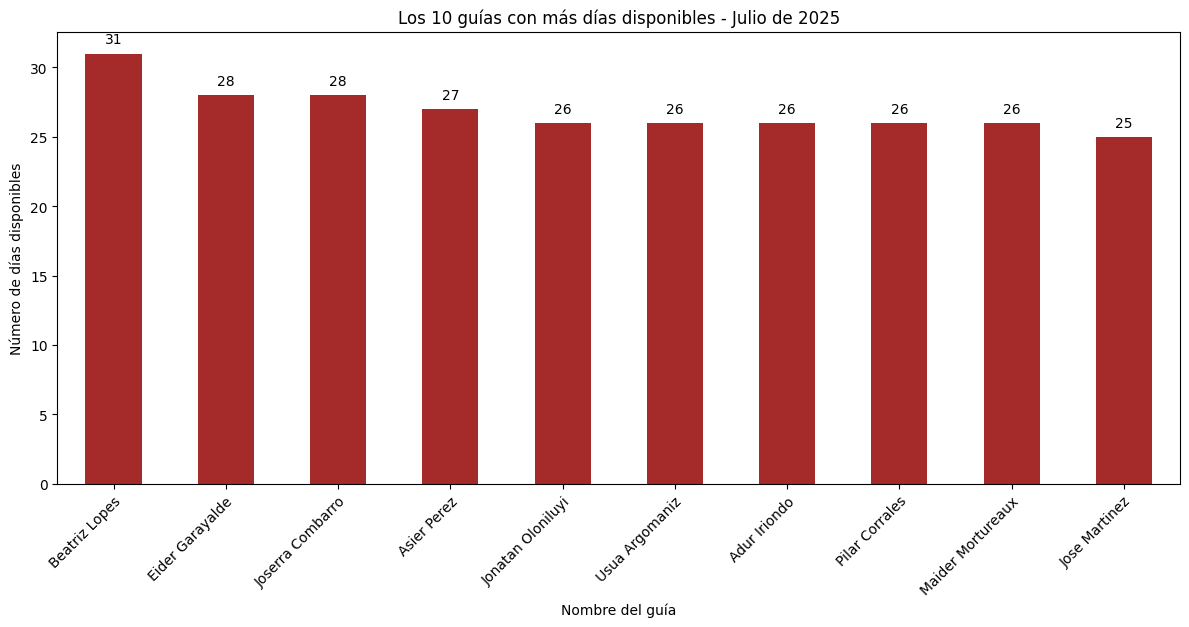

In [418]:
# --- INSIGHT 4.5: Guides with the most availability days for July 2025 ---
# An availability day is any day a guide has at least one available time slot.

# Filter availability records for July 2025
availability_data_07 = availability_days_guides["07"]

# Keep only records where GuideAvailability is present and non-empty
valid_avail_07 = availability_data_07[
    availability_data_07["GuideAvailability"].notna()
    & (availability_data_07["GuideAvailability"] != "")
]

# Count number of distinct available days per guide
available_days_per_guide_07 = (
    valid_avail_07.groupby("GuideName")["AvailabilityDate"]
    .nunique()
    .sort_values(ascending=False)
    .head(10)
)

# Plot the top 10 most available guides
ax = available_days_per_guide_07.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=BAR_COLORS["07"]
)

# Add value labels above each bar
for i, value in enumerate(available_days_per_guide_07.values):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Los 10 guías con más días disponibles - {MONTHS["07"]}'
)  # EN: Top 10 Guides with Most Available Days (July 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)

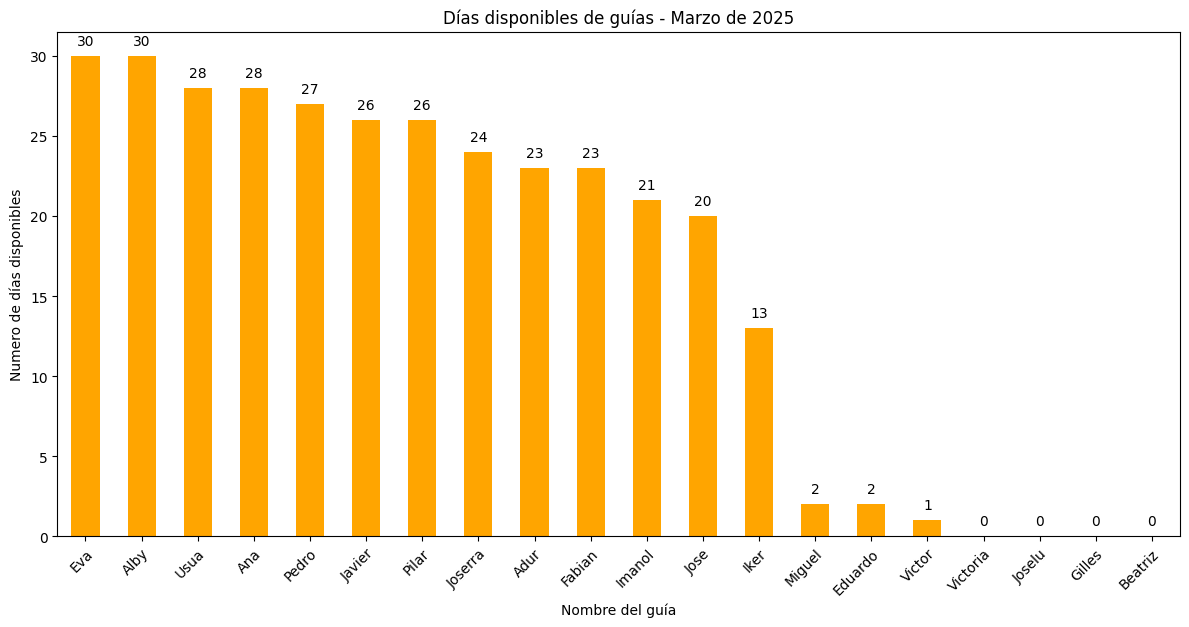

In [419]:
# --- INSIGHT 5.1: Count how many days each guide was available (March 2025) ---
# This plots the number of distinct availability days per guide, not limited to top 10.

# Compute full availability, including 0-day guides
available_days_per_guide_03 = get_days_metric(
    df=valid_avail_03,
    date_col="AvailabilityDate",
    guides_df=guides["03"],
    new_col_name="DaysAvailable"
)

# Plot the results
ax = available_days_per_guide_03.plot(
    kind="bar",
    x="GuideName",
    y="DaysAvailable",
    figsize=DEFAULT_FIGSIZE, 
    color=BAR_COLORS["03"],
    legend= False
)

# Add value labels above bars
for i, value in enumerate(available_days_per_guide_03["DaysAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días disponibles de guías - {MONTHS["03"]}'
)  # EN: Guides' Available Days (March 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Numero de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

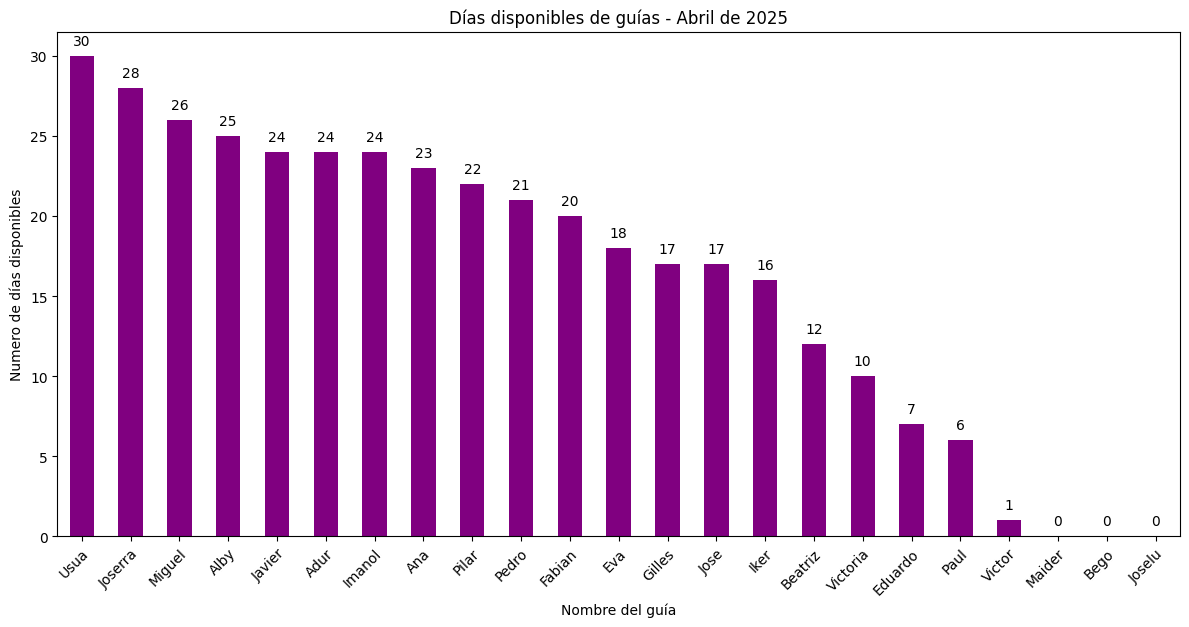

In [420]:
# --- INSIGHT 5.2: Count how many days each guide was available (April 2025) ---
# This plots the number of distinct availability days per guide, not limited to top 10.

# Compute full availability, including 0-day guides
available_days_per_guide_04 = get_days_metric(
    df=valid_avail_04,
    date_col="AvailabilityDate",
    guides_df=guides["04"],
    new_col_name="DaysAvailable"
)

# Plot the results
ax = available_days_per_guide_04.plot(
    kind="bar",
    x="GuideName",
    y="DaysAvailable",
    figsize=DEFAULT_FIGSIZE, 
    color=BAR_COLORS["04"],
    legend= False
)

# Add value labels above bars
for i, value in enumerate(available_days_per_guide_04["DaysAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días disponibles de guías - {MONTHS["04"]}'
)  # EN: Guides' Available Days (April 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Numero de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

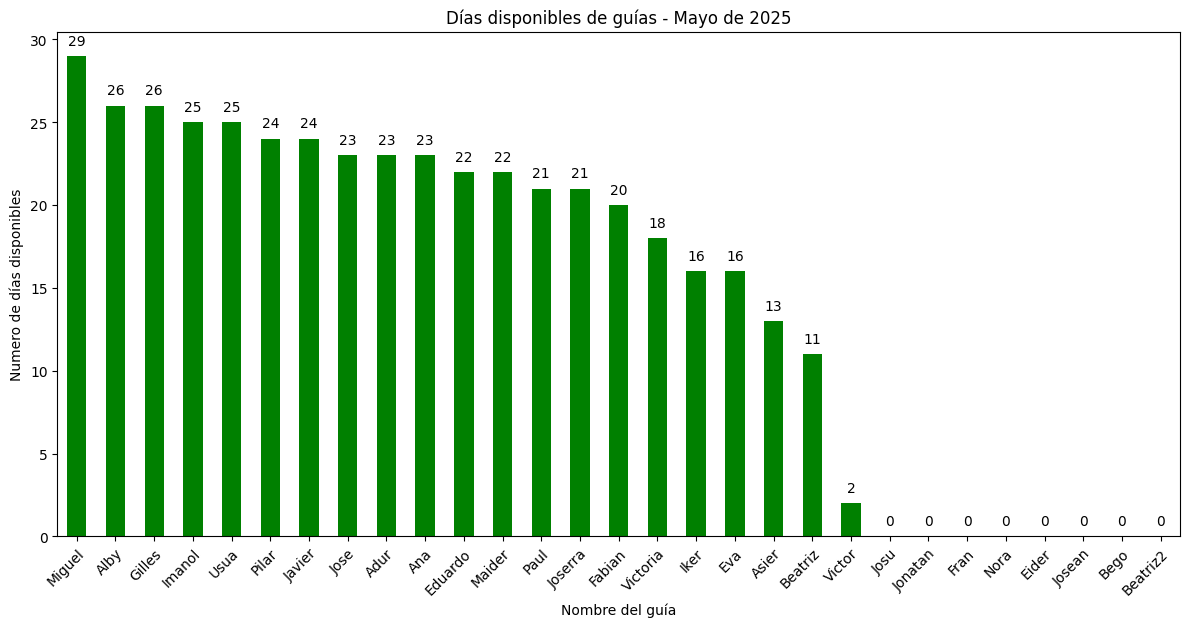

In [421]:
# --- INSIGHT 5.3: Count how many days each guide was available (May 2025) ---
# This plots the number of distinct availability days per guide, not limited to top 10.

# Compute full availability, including 0-day guides
available_days_per_guide_05 = get_days_metric(
    df=valid_avail_05,
    date_col="AvailabilityDate",
    guides_df=guides["05"],
    new_col_name="DaysAvailable"
)

# Plot the results
ax = available_days_per_guide_05.plot(
    kind="bar",
    x="GuideName",
    y="DaysAvailable",
    figsize=DEFAULT_FIGSIZE, 
    color=BAR_COLORS["05"],
    legend= False
)

# Add value labels above bars
for i, value in enumerate(available_days_per_guide_05["DaysAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días disponibles de guías - {MONTHS["05"]}'
)  # EN: Guides' Available Days (May 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Numero de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

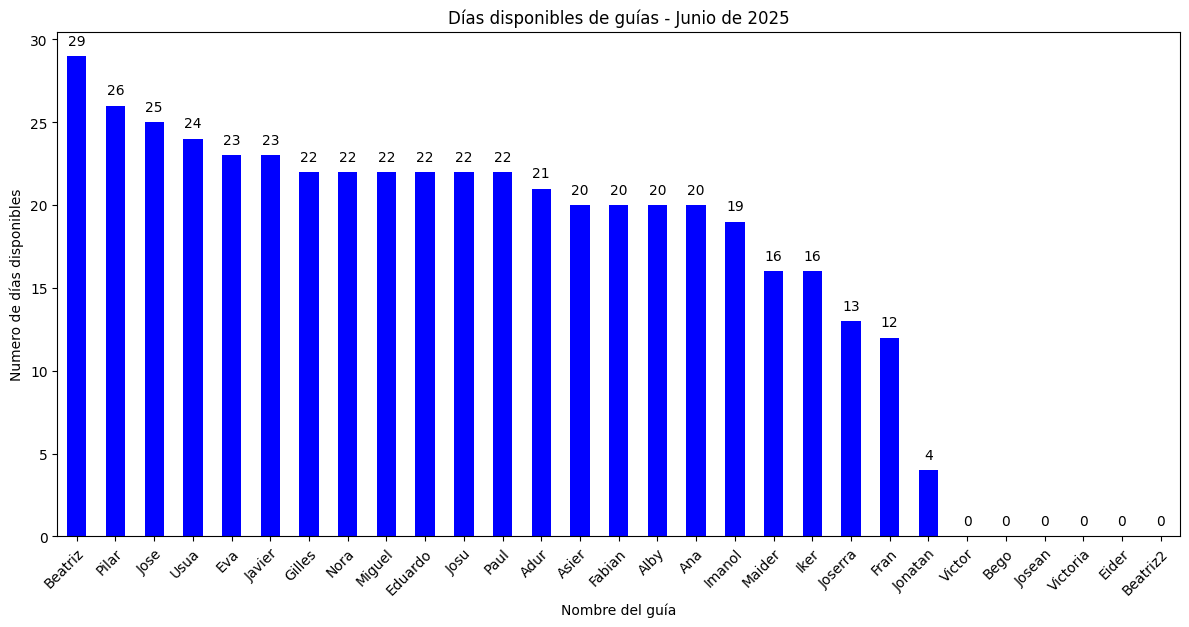

In [422]:
# --- INSIGHT 5.4: Count how many days each guide was available (June 2025) ---
# This plots the number of distinct availability days per guide, not limited to top 10.

# Compute full availability, including 0-day guides
available_days_per_guide_06 = get_days_metric(
    df=valid_avail_06,
    date_col="AvailabilityDate",
    guides_df=guides["06"],
    new_col_name="DaysAvailable"
)

# Plot the results
ax = available_days_per_guide_06.plot(
    kind="bar",
    x="GuideName",
    y="DaysAvailable",
    figsize=DEFAULT_FIGSIZE, 
    color=BAR_COLORS["06"],
    legend= False
)

# Add value labels above bars
for i, value in enumerate(available_days_per_guide_06["DaysAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días disponibles de guías - {MONTHS["06"]}'
)  # EN: Guides' Available Days (June 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Numero de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

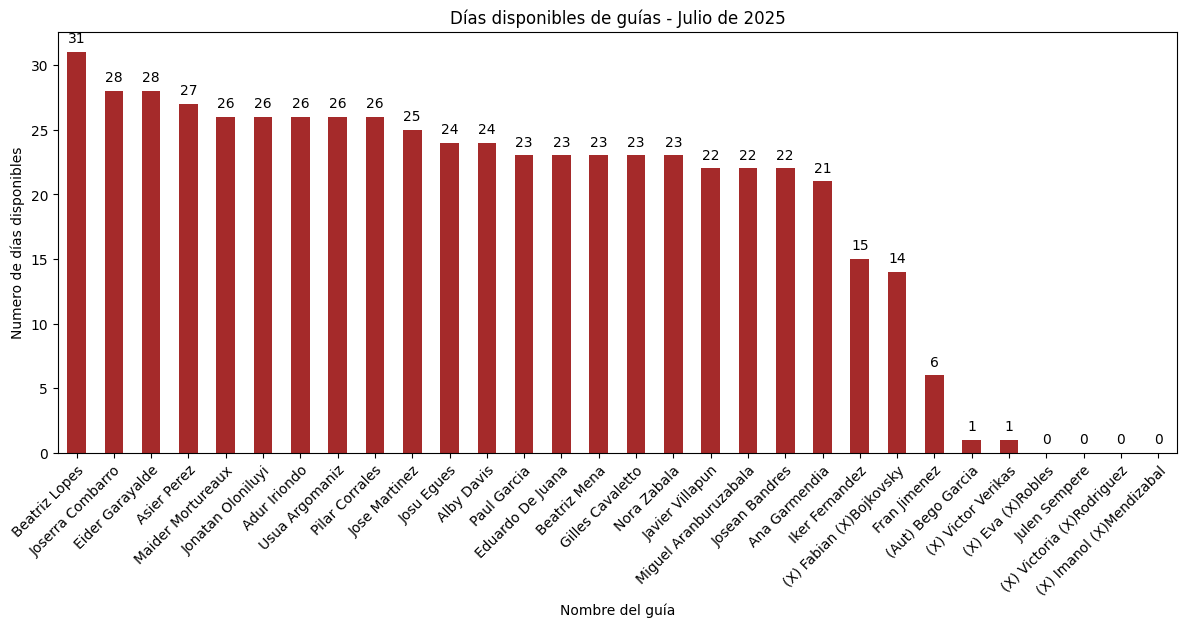

In [423]:
# --- INSIGHT 5.5: Count how many days each guide was available (July 2025) ---
# This plots the number of distinct availability days per guide, not limited to top 10.

# Compute full availability, including 0-day guides
available_days_per_guide_07 = get_days_metric(
    df=valid_avail_07,
    date_col="AvailabilityDate",
    guides_df=guides["07"],
    new_col_name="DaysAvailable"
)

# Plot the results
ax = available_days_per_guide_07.plot(
    kind="bar",
    x="GuideName",
    y="DaysAvailable",
    figsize=DEFAULT_FIGSIZE, 
    color=BAR_COLORS["07"],
    legend= False
)

# Add value labels above bars
for i, value in enumerate(available_days_per_guide_07["DaysAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días disponibles de guías - {MONTHS["07"]}'
)  # EN: Guides' Available Days (July 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Numero de días disponibles")  # EN: Number of Available Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

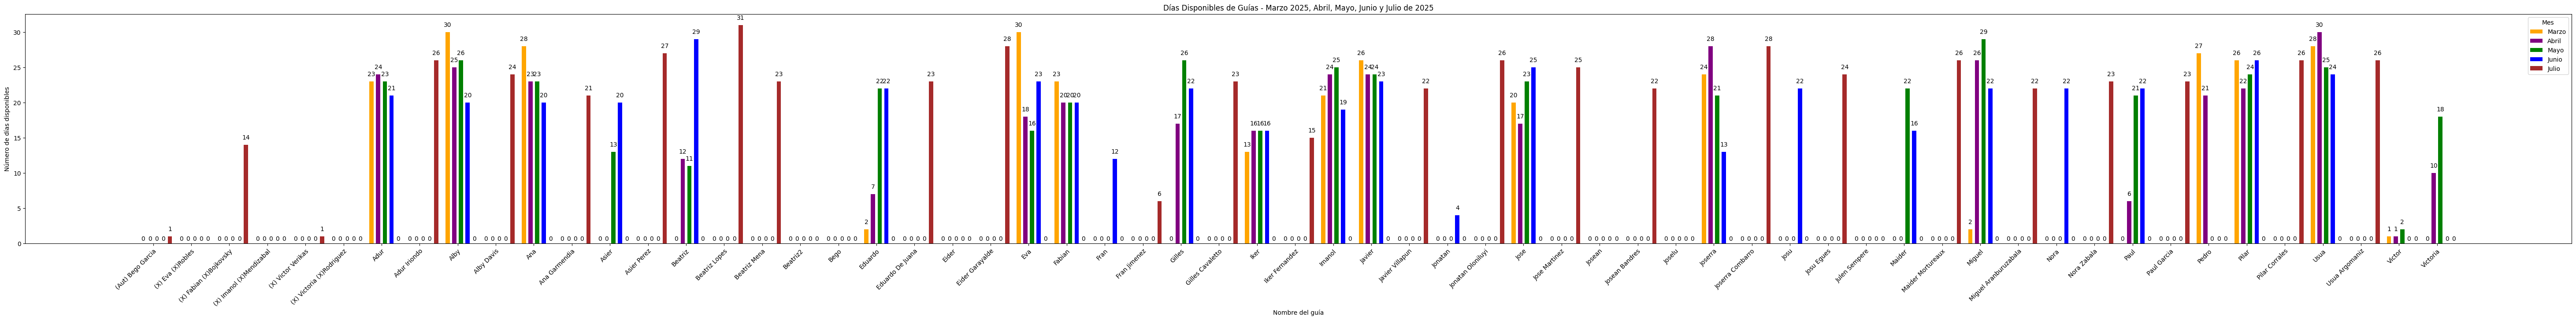

In [424]:
# --- INSIGHT 5.6: Plot guide availability days in March, April, May, June and July 2025 on the same axes ---

# Set reference label for the chart
mm_yy_of_reference = "Marzo 2025, Abril, Mayo, Junio y Julio de 2025"  # set related month

# Step 1: Count the guide availability days for selected months separately
# Use reset_index(name=...) to name the count column directly,
# and rename 'index' to 'Guidename' for clarity

# March
available_days_per_guide_03_df = available_days_per_guide_03.rename(columns={"DaysAvailable": "Marzo"}
) 
# April
available_days_per_guide_04_df = available_days_per_guide_04.rename(columns={"DaysAvailable": "Abril"}
)
# May
available_days_per_guide_05_df = available_days_per_guide_05.rename(columns={"DaysAvailable": "Mayo"}
)
# June
available_days_per_guide_06_df = available_days_per_guide_06.rename(columns={"DaysAvailable": "Junio"}
)
# July
available_days_per_guide_07_df = available_days_per_guide_07.rename(columns={"DaysAvailable": "Julio"}
) 


# Step 2: Merge selected DataFrames on 'GuideName'
# Using 'outer' ensures we include guides that appear in only one of the months
merged = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                available_days_per_guide_03_df,
                available_days_per_guide_04_df,
                on="GuideName",
                how="outer",
            ),
            available_days_per_guide_05_df,
            on="GuideName",
            how="outer",
        ),
        available_days_per_guide_06_df,
        on="GuideName",
        how="outer",
    ),
    available_days_per_guide_07_df,
    on="GuideName",
    how="outer",        
).fillna(0)

# Step 3: Ensure selected columns are integers (not floats from fillna)
merged[["Marzo", "Abril", "Mayo", "Junio", "Julio"]] = merged[
    ["Marzo", "Abril", "Mayo", "Junio", "Julio"]
].astype(int)

# Step 4: Calculate total activity across selected months
merged["Total"] = merged["Marzo"] + merged["Abril"] + merged["Mayo"] + merged["Junio"] + merged["Julio"]

# Step 5: Set guide name as index for plotting
merged.set_index("GuideName", inplace=True)

# Step 6: Plot the bar chart
num_guides = len(merged)
group_spacing = 1.6
fig_width = max(12, len(merged) * group_spacing * 0.6)
fig, ax = plt.subplots(
    figsize=(fig_width, DEFAULT_FIGSIZE[1])
)  # Fixed height, scalable width

# Step 7: Add parameters
bar_width = 0.18
bar_gap = 0.1
group_spacing = 1.6
months = ["Marzo", "Abril", "Mayo", "Junio", "Julio"]
color = [BAR_COLORS["03"], BAR_COLORS["04"], BAR_COLORS["05"], BAR_COLORS["06"], BAR_COLORS["07"]]

x = np.arange(len(merged)) * group_spacing  # One x position for each guide

# Plot bars manually with spacing and labels
for i, (month, color) in enumerate(zip(months, color)):
    offset = (i - 1.5) * (bar_width + bar_gap)
    ax.bar(x + offset, merged[month], width=bar_width, color=color, label=month)

    # Add value labels above each bar
    for j, value in enumerate(merged[month]):
        ax.text(
            x[j] + offset,
            value + 0.8 if value != 0 else 0.4,
            str(value),
            ha="center",
            fontsize=LABEL_FONT_SIZE,
        )

# Step 8: Add chart title and axis labels
ax.set_xticks(x)
ax.set_xticklabels(merged.index, rotation=45, ha="right", rotation_mode="anchor")
ax.set_title(f"Días Disponibles de Guías - {mm_yy_of_reference}")
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de días disponibles")

# Add legend
ax.legend(title="Mes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

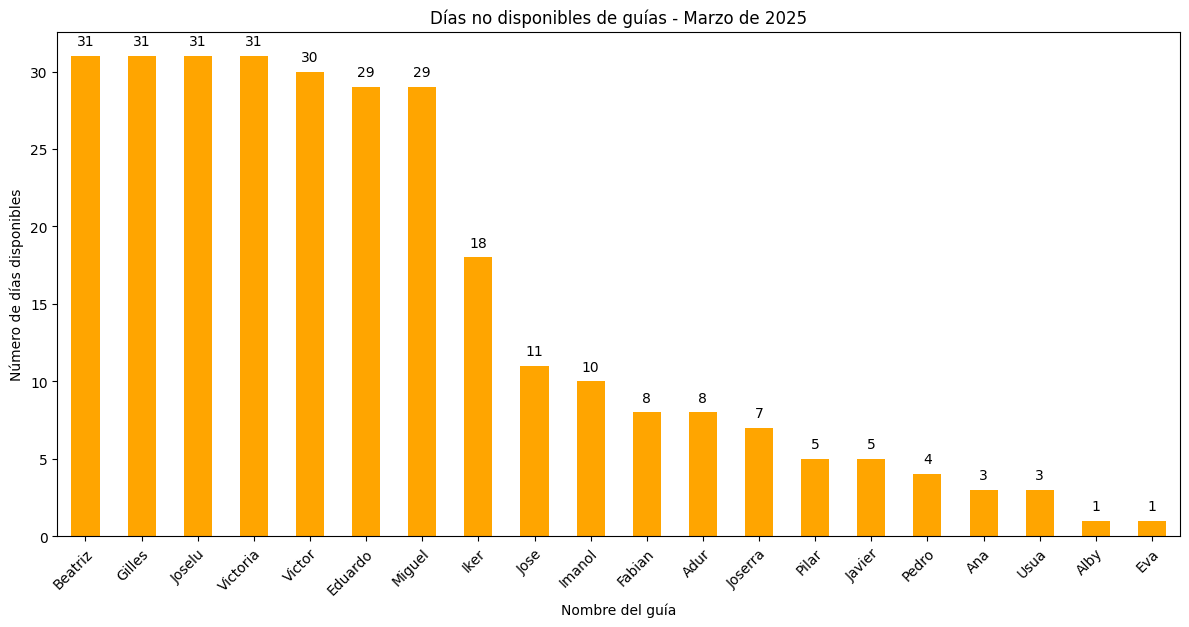

In [425]:
# --- INSIGHT 6.1: Count how many days each guide was not available for March 2025 ---

# Count how many days are in March in Year 2025
days_in_march = calendar.monthrange(YEAR, 3)[1]  # 31 days

# Subtract from full availability DataFrame
not_available_03_2025 = available_days_per_guide_03.copy()
not_available_03_2025["DaysNotAvailable"] = days_in_march - not_available_03_2025["DaysAvailable"]

# Sort descending by DaysNotAvailable
not_available_03_2025 = not_available_03_2025.sort_values("DaysNotAvailable", ascending=False)

# Plot
ax = not_available_03_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysNotAvailable",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["03"],
    legend=False
)

# Add value labels above each bar
for i, value in enumerate(not_available_03_2025["DaysNotAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Días no disponibles de guías - {MONTHS["03"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de días disponibles")

# Styling
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

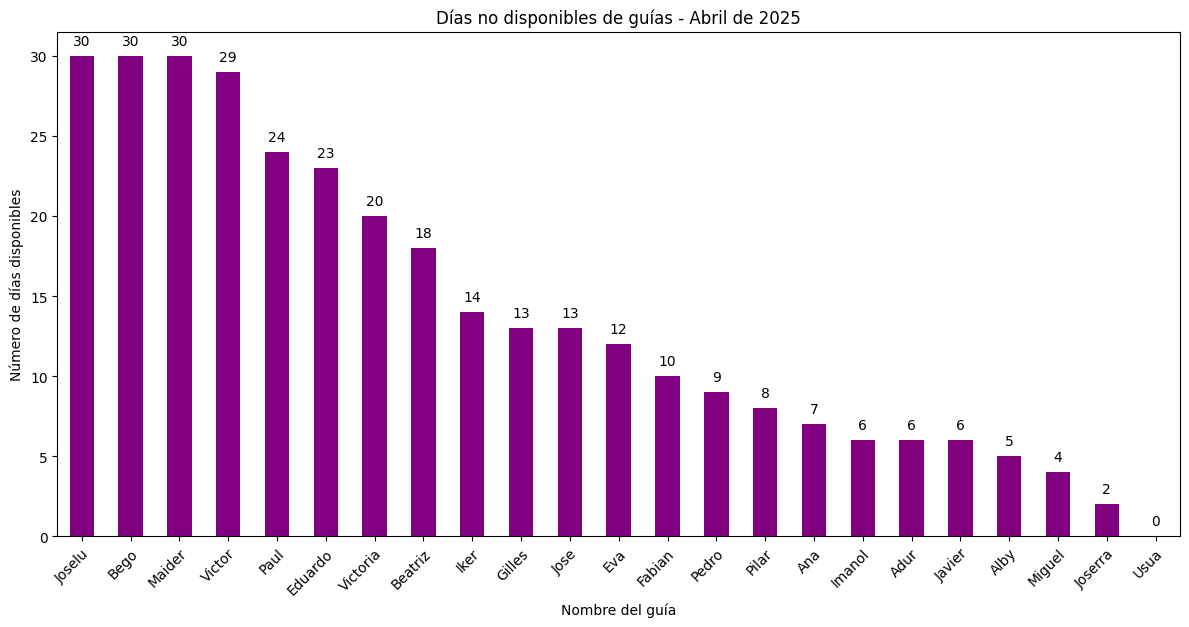

In [426]:
# --- INSIGHT 6.2: Count how many days each guide was not available for April 2025 ---

# Count how many days are in April in Year 2025
days_in_april = calendar.monthrange(YEAR, 4)[1]  # 30 days

# Subtract from full availability DataFrame
not_available_04_2025 = available_days_per_guide_04.copy()
not_available_04_2025["DaysNotAvailable"] = days_in_april - not_available_04_2025["DaysAvailable"]

# Sort descending by DaysNotAvailable
not_available_04_2025 = not_available_04_2025.sort_values("DaysNotAvailable", ascending=False)

# Plot
ax = not_available_04_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysNotAvailable",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["04"],
    legend=False
)

# Add value labels above each bar
for i, value in enumerate(not_available_04_2025["DaysNotAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Días no disponibles de guías - {MONTHS["04"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de días disponibles")

# Styling
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

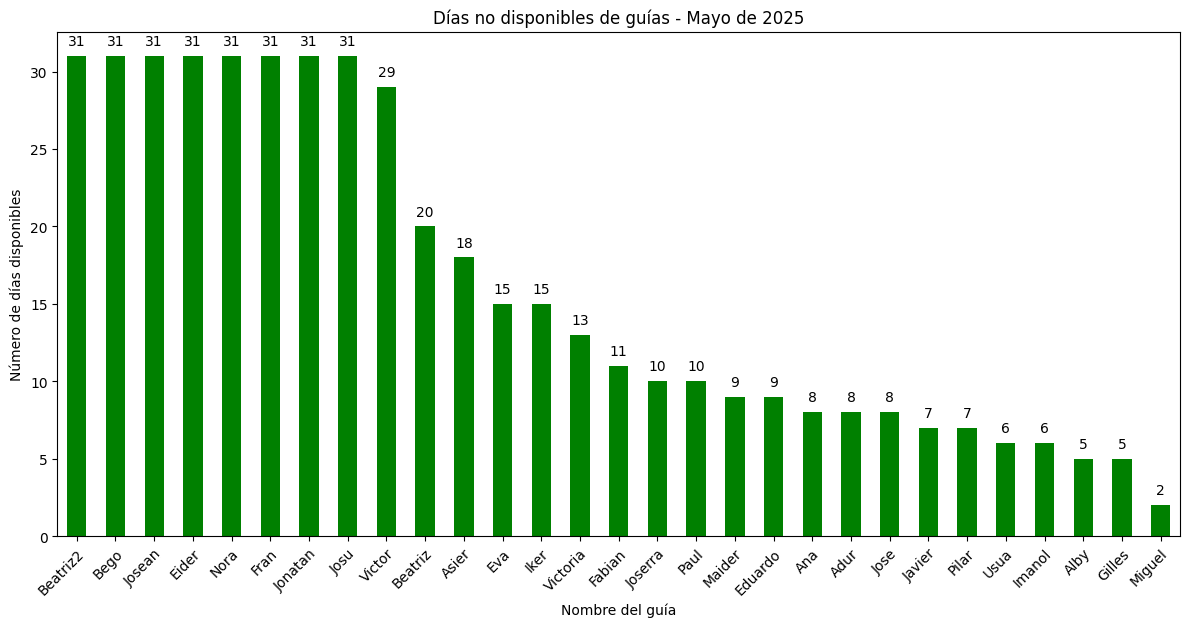

In [427]:
# --- INSIGHT 6.3: Count how many days each guide was not available for May 2025 ---

# Count how many days are in May in Year 2025
days_in_may = calendar.monthrange(YEAR, 5)[1]  # 31 days

# Subtract from full availability DataFrame
not_available_05_2025 = available_days_per_guide_05.copy()
not_available_05_2025["DaysNotAvailable"] = days_in_may - not_available_05_2025["DaysAvailable"]

# Sort descending by DaysNotAvailable
not_available_05_2025 = not_available_05_2025.sort_values("DaysNotAvailable", ascending=False)

# Plot
ax = not_available_05_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysNotAvailable",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["05"],
    legend=False
)

# Add value labels above each bar
for i, value in enumerate(not_available_05_2025["DaysNotAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Días no disponibles de guías - {MONTHS["05"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de días disponibles")

# Styling
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

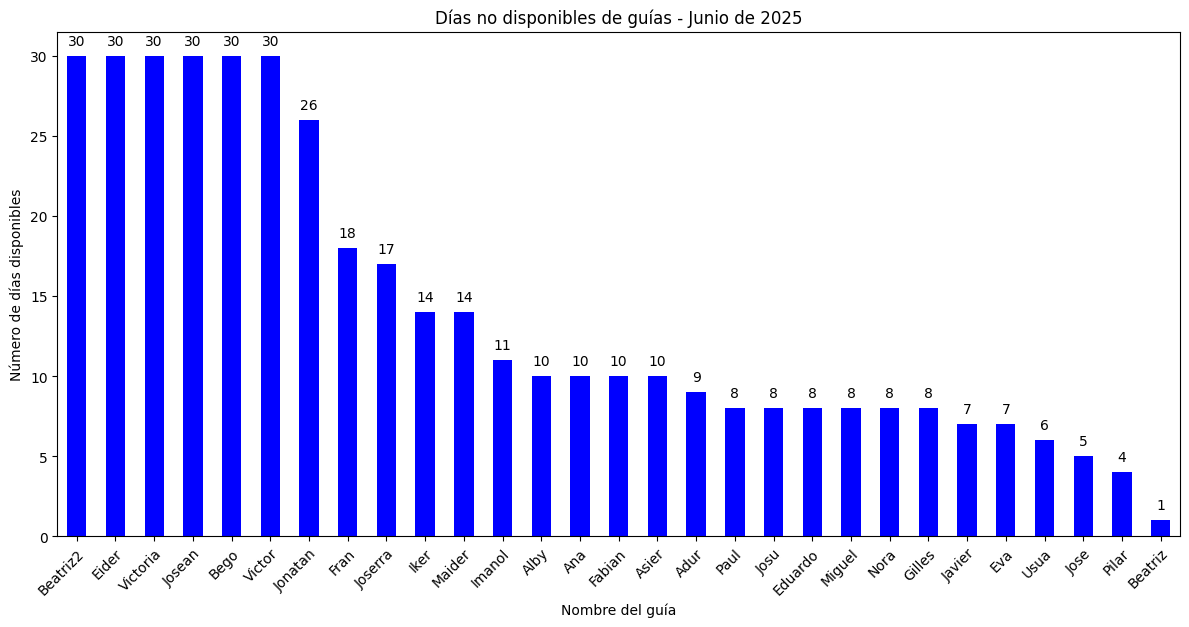

In [428]:
# --- INSIGHT 6.4: Count how many days each guide was not available for June 2025 ---

# Count how many days are in June in Year 2025
days_in_june = calendar.monthrange(YEAR, 6)[1]  # 30 days

# Subtract from full availability DataFrame
not_available_06_2025 = available_days_per_guide_06.copy()
not_available_06_2025["DaysNotAvailable"] = days_in_june - not_available_06_2025["DaysAvailable"]

# Sort descending by DaysNotAvailable
not_available_06_2025 = not_available_06_2025.sort_values("DaysNotAvailable", ascending=False)

# Plot
ax = not_available_06_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysNotAvailable",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["06"],
    legend=False
)

# Add value labels above each bar
for i, value in enumerate(not_available_06_2025["DaysNotAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Días no disponibles de guías - {MONTHS["06"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de días disponibles")

# Styling
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

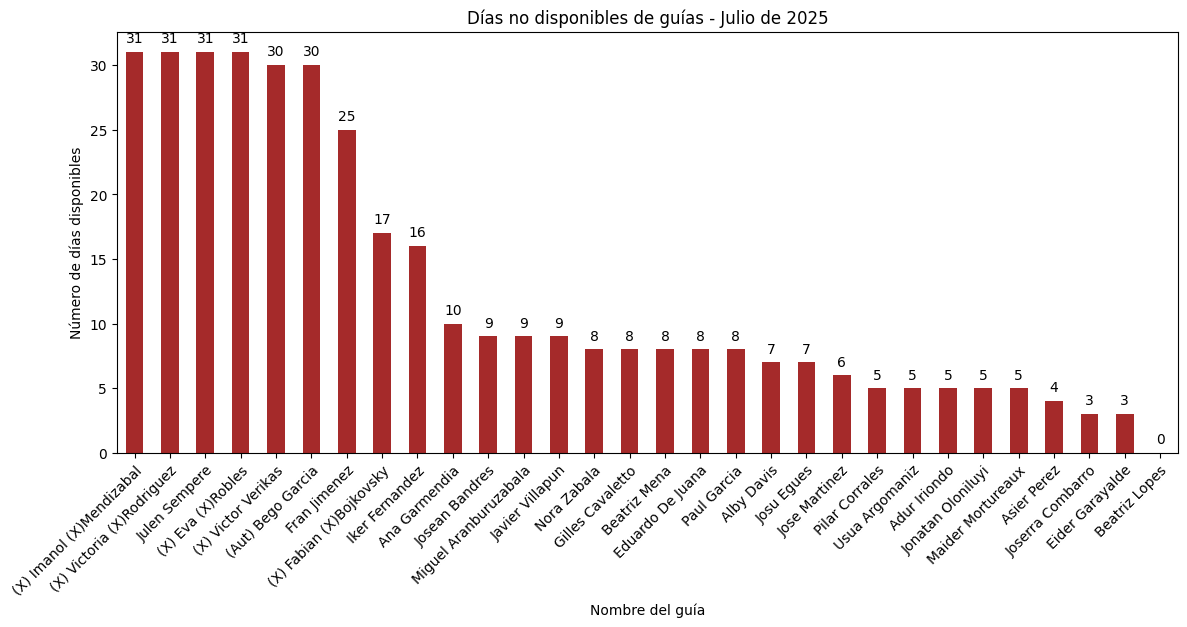

In [429]:
# --- INSIGHT 6.5: Count how many days each guide was not available for July 2025 ---

# Count how many days are in July in 2025
days_in_july = calendar.monthrange(YEAR, 7)[1]  # 31 days

# Subtract from full availability DataFrame
not_available_07_2025 = available_days_per_guide_07.copy()
not_available_07_2025["DaysNotAvailable"] = days_in_july - not_available_07_2025["DaysAvailable"]

# Sort descending by DaysNotAvailable
not_available_07_2025 = not_available_07_2025.sort_values("DaysNotAvailable", ascending=False)

# Plot
ax = not_available_07_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysNotAvailable",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["07"],
    legend=False
)

# Add value labels above each bar
for i, value in enumerate(not_available_07_2025["DaysNotAvailable"]):
    ax.text(
        i, value + 0.5, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Días no disponibles de guías - {MONTHS["07"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de días disponibles")

# Styling
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

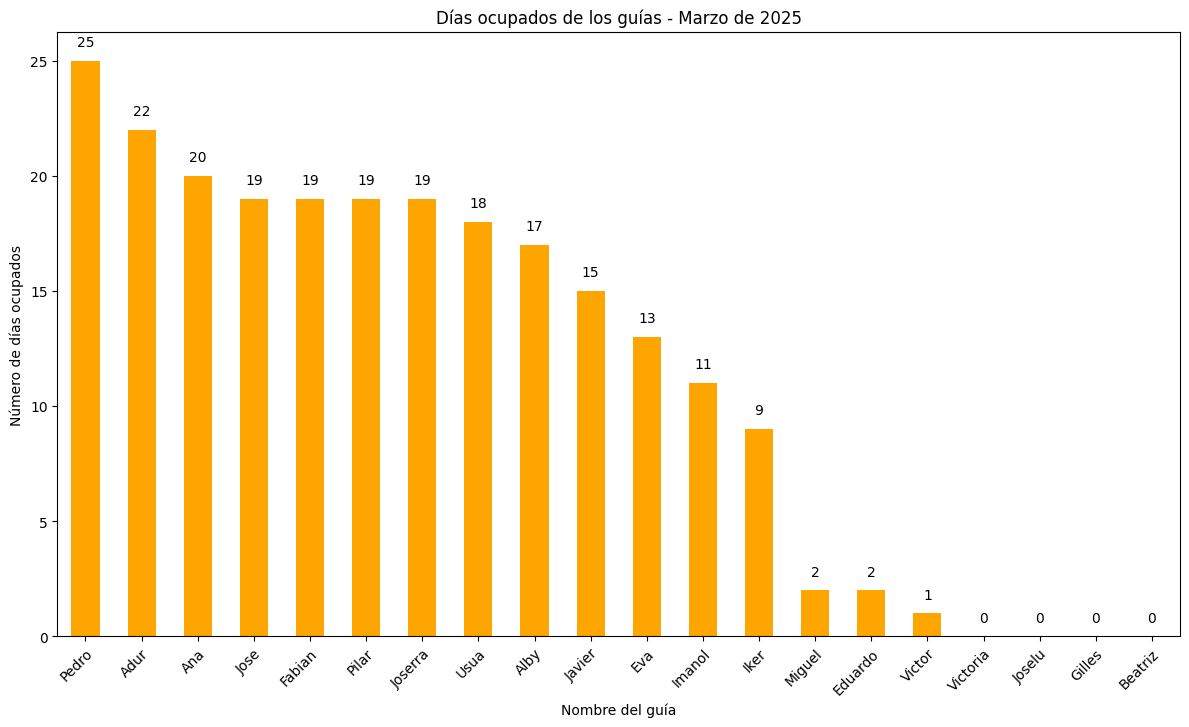

In [430]:
# --- INSIGHT 7.1: Count how many days guides were occupied for March 2025 ---

# Compute days occupied, including guides with 0 bookings

occupied_days_03_2025 = get_days_metric(
    df=bookings_merged["03"],
    date_col="BookingDate",
    guides_df=guides["03"],
    new_col_name="DaysOccupied"
)

# Plot
ax = occupied_days_03_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysOccupied",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["03"],
    legend=False
)

# Add value labels above bars
for i, days in enumerate(occupied_days_03_2025["DaysOccupied"]):
    ax.text(
        i, days + 0.5, str(days), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días ocupados de los guías - {MONTHS["03"]}'
)  # EN: Guides' Occupied Days (March 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días ocupados")  # EN: Number of Occupied Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

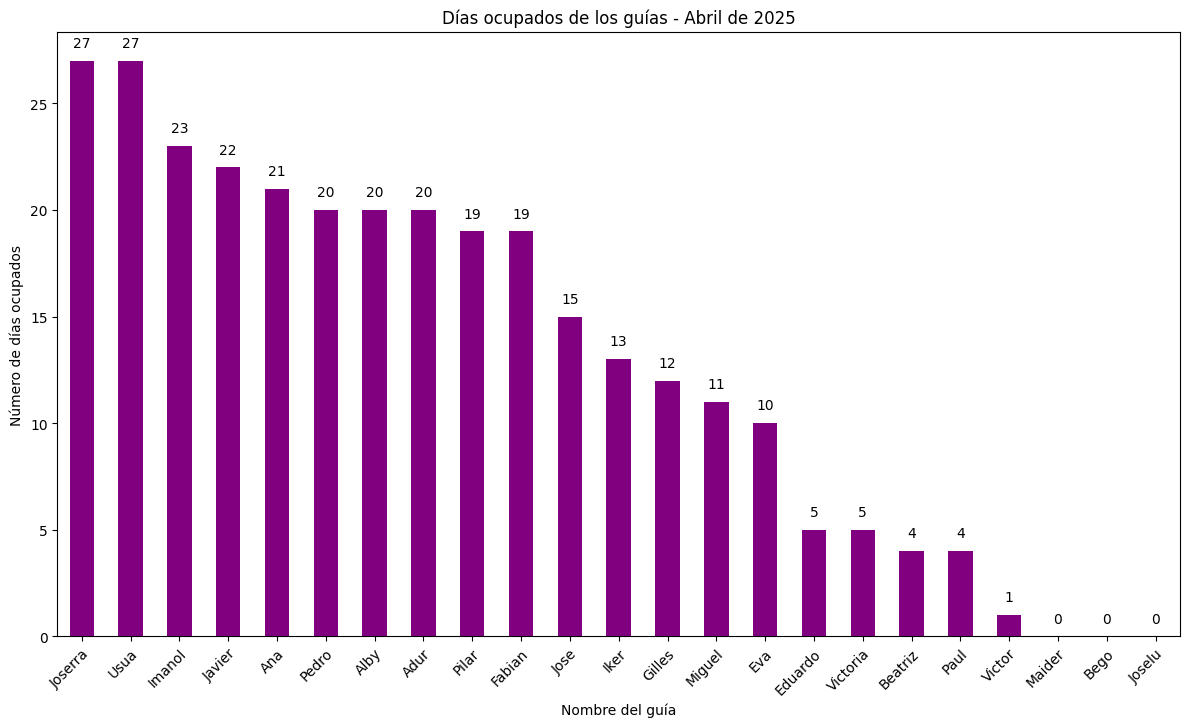

In [431]:
# --- INSIGHT 7.2: Count how many days guides were occupied for April 2025 ---

# Compute days occupied, including guides with 0 bookings

occupied_days_04_2025 = get_days_metric(
    df=bookings_merged["04"],
    date_col="BookingDate",
    guides_df=guides["04"],
    new_col_name="DaysOccupied"
)

# Plot
ax = occupied_days_04_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysOccupied",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["04"],
    legend=False
)

# Add value labels above bars
for i, days in enumerate(occupied_days_04_2025["DaysOccupied"]):
    ax.text(
        i, days + 0.5, str(days), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días ocupados de los guías - {MONTHS["04"]}'
)  # EN: Guides' Occupied Days (April 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días ocupados")  # EN: Number of Occupied Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

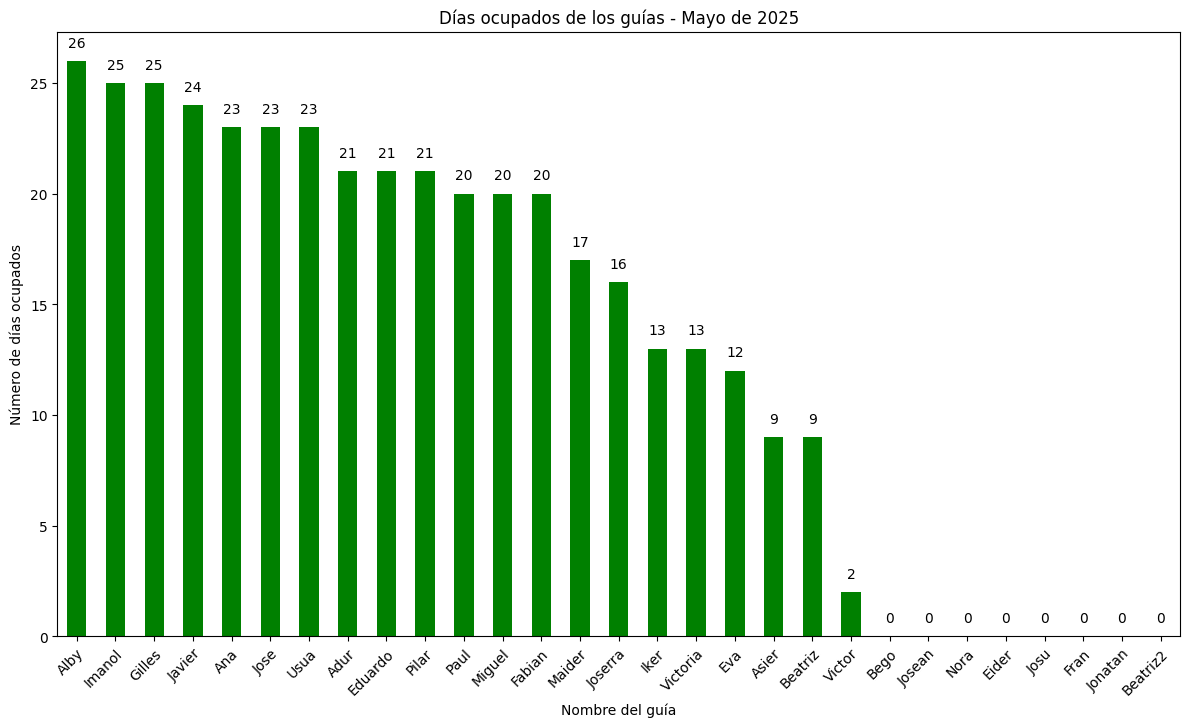

In [432]:
# --- INSIGHT 7.3: Count how many days guides were occupied for May 2025 ---

# Compute days occupied, including guides with 0 bookings

occupied_days_05_2025 = get_days_metric(
    df=bookings_merged["05"],
    date_col="BookingDate",
    guides_df=guides["05"],
    new_col_name="DaysOccupied"
)

# Plot
ax = occupied_days_05_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysOccupied",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["05"],
    legend=False
)

# Add value labels above bars
for i, days in enumerate(occupied_days_05_2025["DaysOccupied"]):
    ax.text(
        i, days + 0.5, str(days), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días ocupados de los guías - {MONTHS["05"]}'
)  # EN: Guides' Occupied Days (May 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días ocupados")  # EN: Number of Occupied Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

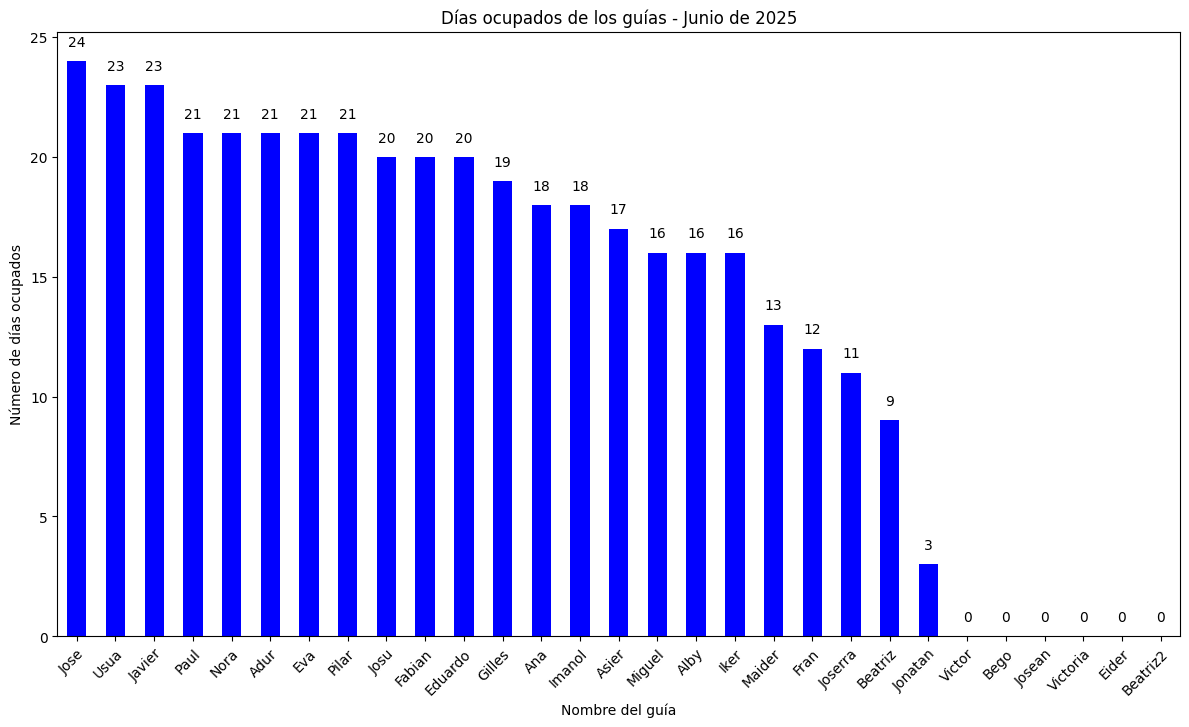

In [433]:
# --- INSIGHT 7.4: Count how many days guides were occupied for June 2025 ---


# Compute days occupied, including guides with 0 bookings

occupied_days_06_2025 = get_days_metric(
    df=bookings_merged["06"],
    date_col="BookingDate",
    guides_df=guides["06"],
    new_col_name="DaysOccupied"
)

# Plot
ax = occupied_days_06_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysOccupied",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["06"],
    legend=False
)

# Add value labels above bars
for i, days in enumerate(occupied_days_06_2025["DaysOccupied"]):
    ax.text(
        i, days + 0.5, str(days), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días ocupados de los guías - {MONTHS["06"]}'
)  # EN: Guides' Occupied Days (June 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días ocupados")  # EN: Number of Occupied Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

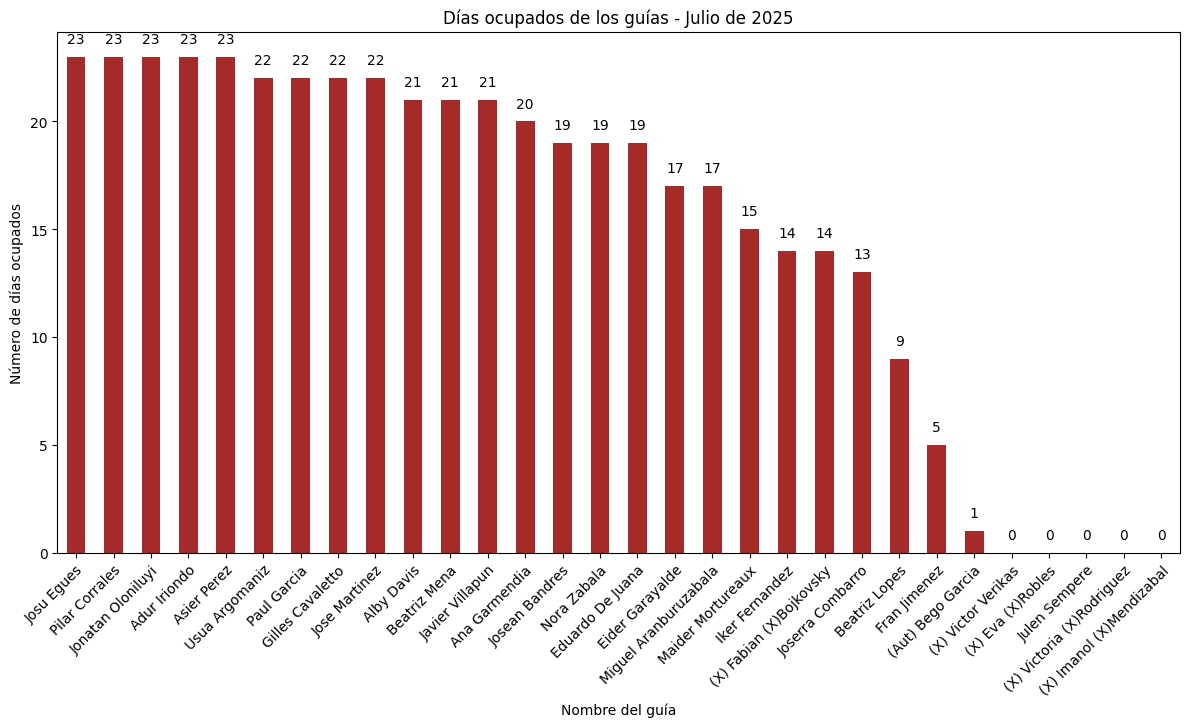

In [434]:
# --- INSIGHT 7.5: Count how many days guides were occupied for July 2025 ---


# Compute days occupied, including guides with 0 bookings

occupied_days_07_2025 = get_days_metric(
    df=bookings_merged["07"],
    date_col="BookingDate",
    guides_df=guides["07"],
    new_col_name="DaysOccupied"
)

# Plot
ax = occupied_days_07_2025.plot(
    kind="bar",
    x="GuideName",
    y="DaysOccupied",
    figsize=DEFAULT_FIGSIZE,
    color=BAR_COLORS["07"],
    legend=False
)

# Add value labels above bars
for i, days in enumerate(occupied_days_07_2025["DaysOccupied"]):
    ax.text(
        i, days + 0.5, str(days), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Set plot title and axis labels
ax.set_title(
    f'Días ocupados de los guías - {MONTHS["07"]}'
)  # EN: Guides' Occupied Days (July 2025)
ax.set_xlabel("Nombre del guía")  # EN: Guide Name
ax.set_ylabel("Número de días ocupados")  # EN: Number of Occupied Days
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.subplots_adjust(top=1.4)
plt.show()

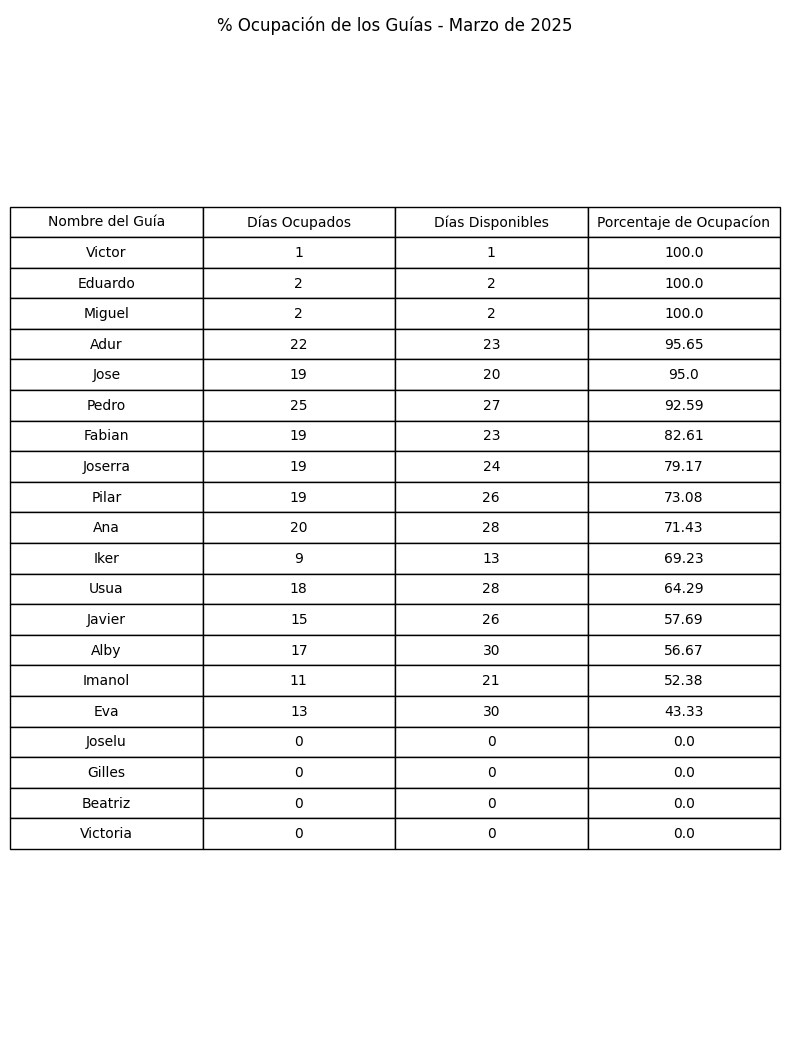

In [435]:
# --- INSIGHT 8.1: Calculate Occupancy Rate for March 2025 ---
# Occupancy Rate = (DaysOccupied / AvailableDays) * 100

# Convert to Series indexed by GuideName
occupied_days_series_03_2025 = occupied_days_03_2025.set_index("GuideName")["DaysOccupied"]
available_days_series = available_days_per_guide_03.set_index("GuideName")["DaysAvailable"]

# Combine into one DataFrame
stats = pd.DataFrame(
    {
        "DaysOccupied": occupied_days_series_03_2025,
        "AvailableDays": available_days_series,
    }
)
# Compute Occupancy %
stats["OccupancyPct"] = (stats["DaysOccupied"] / stats["AvailableDays"] * 100).round(2)

# Handle division by 0 (optional: set to 0 or NaN as needed)
stats["OccupancyPct"] = stats["OccupancyPct"].fillna(0)

# Sort by occupancy rate descending
stats_sorted_03_2025 = stats.sort_values(["OccupancyPct"], ascending=False)

# Reset index for tabular plotting
occupancy_table_03_2025 = stats_sorted_03_2025.reset_index(names="GuideName")[
    ["GuideName", "DaysOccupied", "AvailableDays", "OccupancyPct"]
]

# --- Plot the table ---
translated_labels = [
    "Nombre del Guía",
    "Días Ocupados",
    "Días Disponibles",
    "Porcentaje de Ocupacíon",
]

fig, ax = plt.subplots(figsize=(8, len(occupancy_table_03_2025) * 0.5 + 1))
ax.axis("off")  # Hide axes

# Create the table
tbl = ax.table(
    cellText=occupancy_table_03_2025.values,
    colLabels=translated_labels,
    cellLoc="center",
    loc="center",
)

# Styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Title and layout
plt.suptitle(f'% Ocupación de los Guías - {MONTHS["03"]}', y=0.95, fontsize=12)
plt.tight_layout()
plt.show()

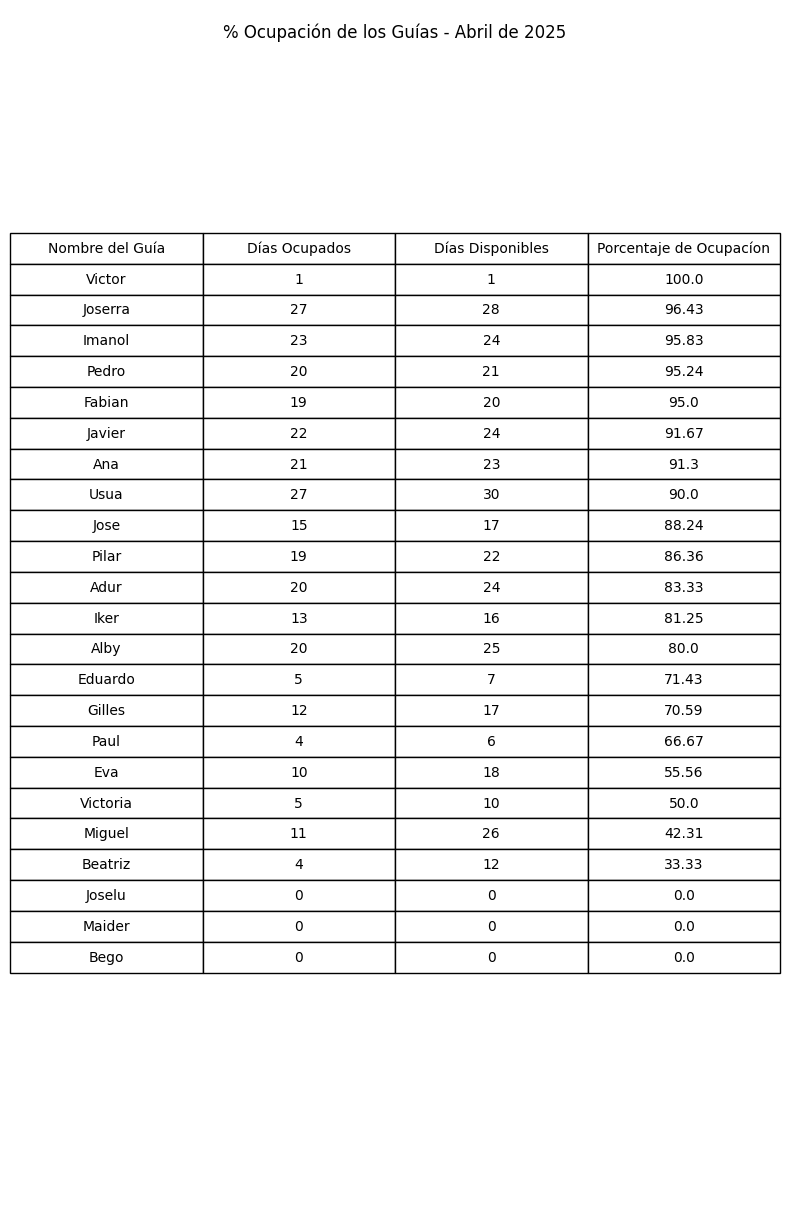

In [436]:
# --- INSIGHT 8.2: Calculate Occupancy Rate for April 2025 ---
# Occupancy Rate = (DaysOccupied / AvailableDays) * 100

# Convert to Series indexed by GuideName
occupied_days_series_04_2025 = occupied_days_04_2025.set_index("GuideName")["DaysOccupied"]
available_days_series = available_days_per_guide_04.set_index("GuideName")["DaysAvailable"]

# Combine into one DataFrame
stats = pd.DataFrame(
    {
        "DaysOccupied": occupied_days_series_04_2025,
        "AvailableDays": available_days_series,
    }
)
# Compute Occupancy %
stats["OccupancyPct"] = (stats["DaysOccupied"] / stats["AvailableDays"] * 100).round(2)

# Handle division by 0 (optional: set to 0 or NaN as needed)
stats["OccupancyPct"] = stats["OccupancyPct"].fillna(0)

# Sort by occupancy rate descending
stats_sorted_04_2025 = stats.sort_values(["OccupancyPct"], ascending=False)

# Reset index for tabular plotting
occupancy_table_04_2025 = stats_sorted_04_2025.reset_index(names="GuideName")[
    ["GuideName", "DaysOccupied", "AvailableDays", "OccupancyPct"]
]

# --- Plot the table ---
translated_labels = [
    "Nombre del Guía",
    "Días Ocupados",
    "Días Disponibles",
    "Porcentaje de Ocupacíon",
]

fig, ax = plt.subplots(figsize=(8, len(occupancy_table_04_2025) * 0.5 + 1))
ax.axis("off")  # Hide axes

# Create the table
tbl = ax.table(
    cellText=occupancy_table_04_2025.values,
    colLabels=translated_labels,
    cellLoc="center",
    loc="center",
)

# Styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Title and layout
plt.suptitle(f'% Ocupación de los Guías - {MONTHS["04"]}', y=0.95, fontsize=12)
plt.tight_layout()
plt.show()

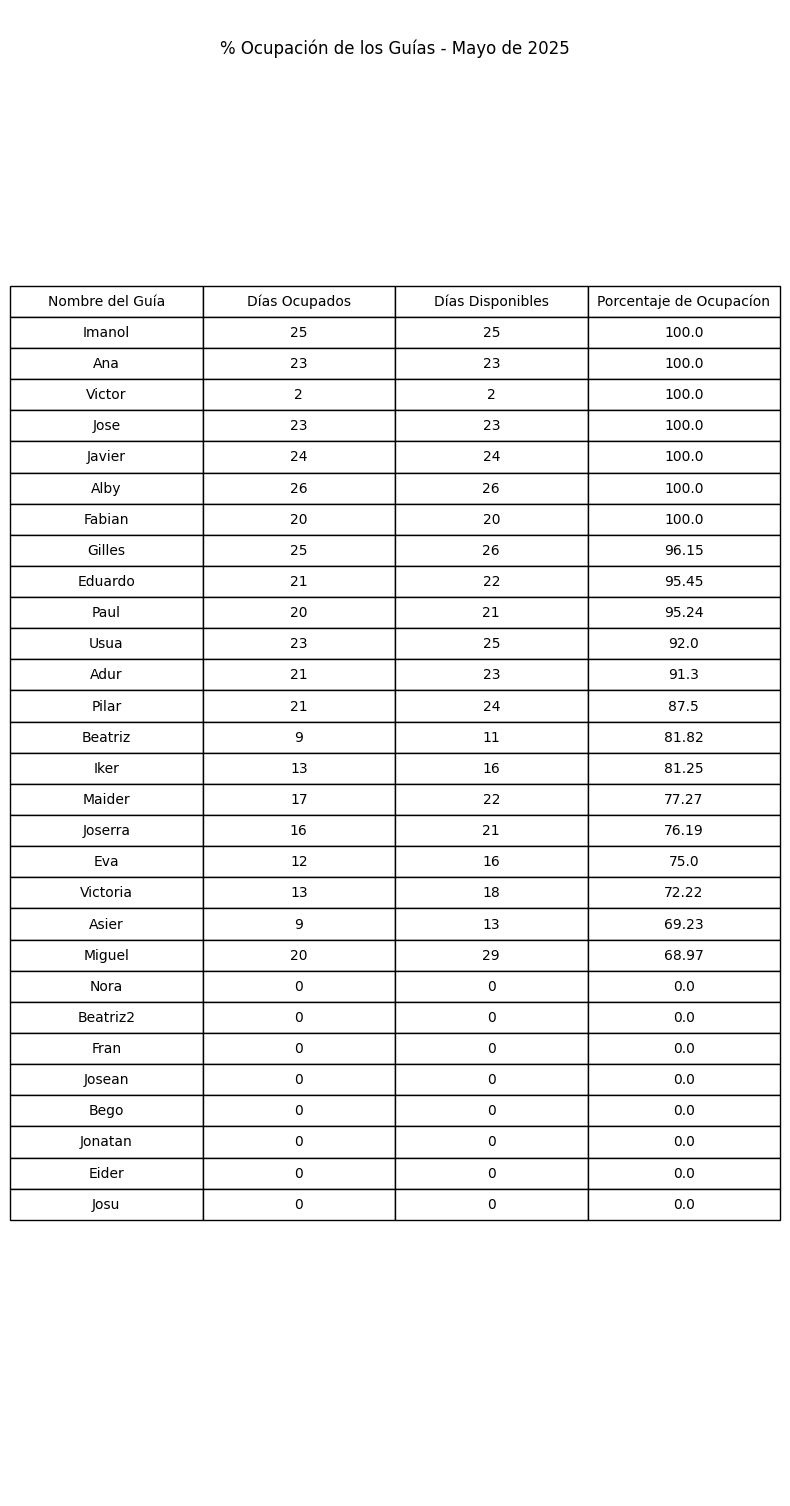

In [437]:
# --- INSIGHT 8.3: Calculate Occupancy Rate for May 2025 ---
# Occupancy Rate = (DaysOccupied / AvailableDays) * 100

# Convert to Series indexed by GuideName
occupied_days_series_05_2025 = occupied_days_05_2025.set_index("GuideName")["DaysOccupied"]
available_days_series = available_days_per_guide_05.set_index("GuideName")["DaysAvailable"]

# Combine into one DataFrame
stats = pd.DataFrame(
    {
        "DaysOccupied": occupied_days_series_05_2025,
        "AvailableDays": available_days_series,
    }
)
# Compute Occupancy %
stats["OccupancyPct"] = (stats["DaysOccupied"] / stats["AvailableDays"] * 100).round(2)

# Handle division by 0 (optional: set to 0 or NaN as needed)
stats["OccupancyPct"] = stats["OccupancyPct"].fillna(0)

# Sort by occupancy rate descending
stats_sorted_05_2025 = stats.sort_values(["OccupancyPct"], ascending=False)

# Reset index for tabular plotting
occupancy_table_05_2025 = stats_sorted_05_2025.reset_index(names="GuideName")[
    ["GuideName", "DaysOccupied", "AvailableDays", "OccupancyPct"]
]

# --- Plot the table ---
translated_labels = [
    "Nombre del Guía",
    "Días Ocupados",
    "Días Disponibles",
    "Porcentaje de Ocupacíon",
]

fig, ax = plt.subplots(figsize=(8, len(occupancy_table_05_2025) * 0.5 + 1))
ax.axis("off")  # Hide axes

# Create the table
tbl = ax.table(
    cellText=occupancy_table_05_2025.values,
    colLabels=translated_labels,
    cellLoc="center",
    loc="center",
)

# Styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Title and layout
plt.suptitle(f'% Ocupación de los Guías - {MONTHS["05"]}', y=0.95, fontsize=12)
plt.tight_layout()
plt.show()

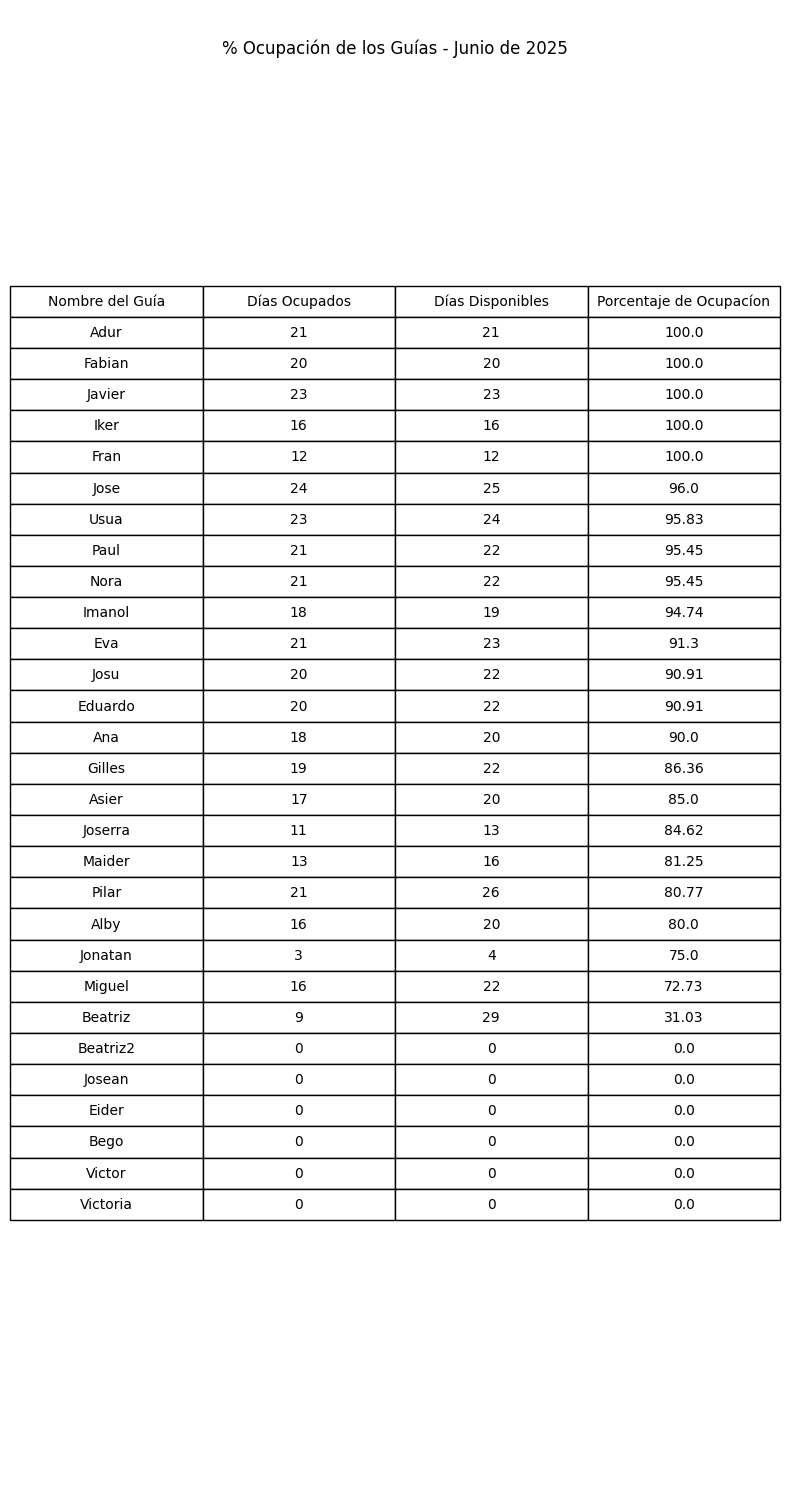

In [438]:
# --- INSIGHT 8.4: Calculate Occupancy Rate for June 2025 ---
# Occupancy Rate = (DaysOccupied / AvailableDays) * 100


# Convert to Series indexed by GuideName
occupied_days_series_06_2025 = occupied_days_06_2025.set_index("GuideName")["DaysOccupied"]
available_days_series = available_days_per_guide_06.set_index("GuideName")["DaysAvailable"]

# Combine into one DataFrame
stats = pd.DataFrame(
    {
        "DaysOccupied": occupied_days_series_06_2025,
        "AvailableDays": available_days_series,
    }
)
# Compute Occupancy %
stats["OccupancyPct"] = (stats["DaysOccupied"] / stats["AvailableDays"] * 100).round(2)

# Handle division by 0 (optional: set to 0 or NaN as needed)
stats["OccupancyPct"] = stats["OccupancyPct"].fillna(0)

# Sort by occupancy rate descending
stats_sorted_06_2025 = stats.sort_values(["OccupancyPct"], ascending=False)

# Reset index for tabular plotting
occupancy_table_06_2025 = stats_sorted_06_2025.reset_index(names="GuideName")[
    ["GuideName", "DaysOccupied", "AvailableDays", "OccupancyPct"]
]

# --- Plot the table ---
translated_labels = [
    "Nombre del Guía",
    "Días Ocupados",
    "Días Disponibles",
    "Porcentaje de Ocupacíon",
]

fig, ax = plt.subplots(figsize=(8, len(occupancy_table_06_2025) * 0.5 + 1))
ax.axis("off")  # Hide axes

# Create the table
tbl = ax.table(
    cellText=occupancy_table_06_2025.values,
    colLabels=translated_labels,
    cellLoc="center",
    loc="center",
)

# Styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Title and layout
plt.suptitle(f'% Ocupación de los Guías - {MONTHS["06"]}', y=0.95, fontsize=12)
plt.tight_layout()
plt.show()

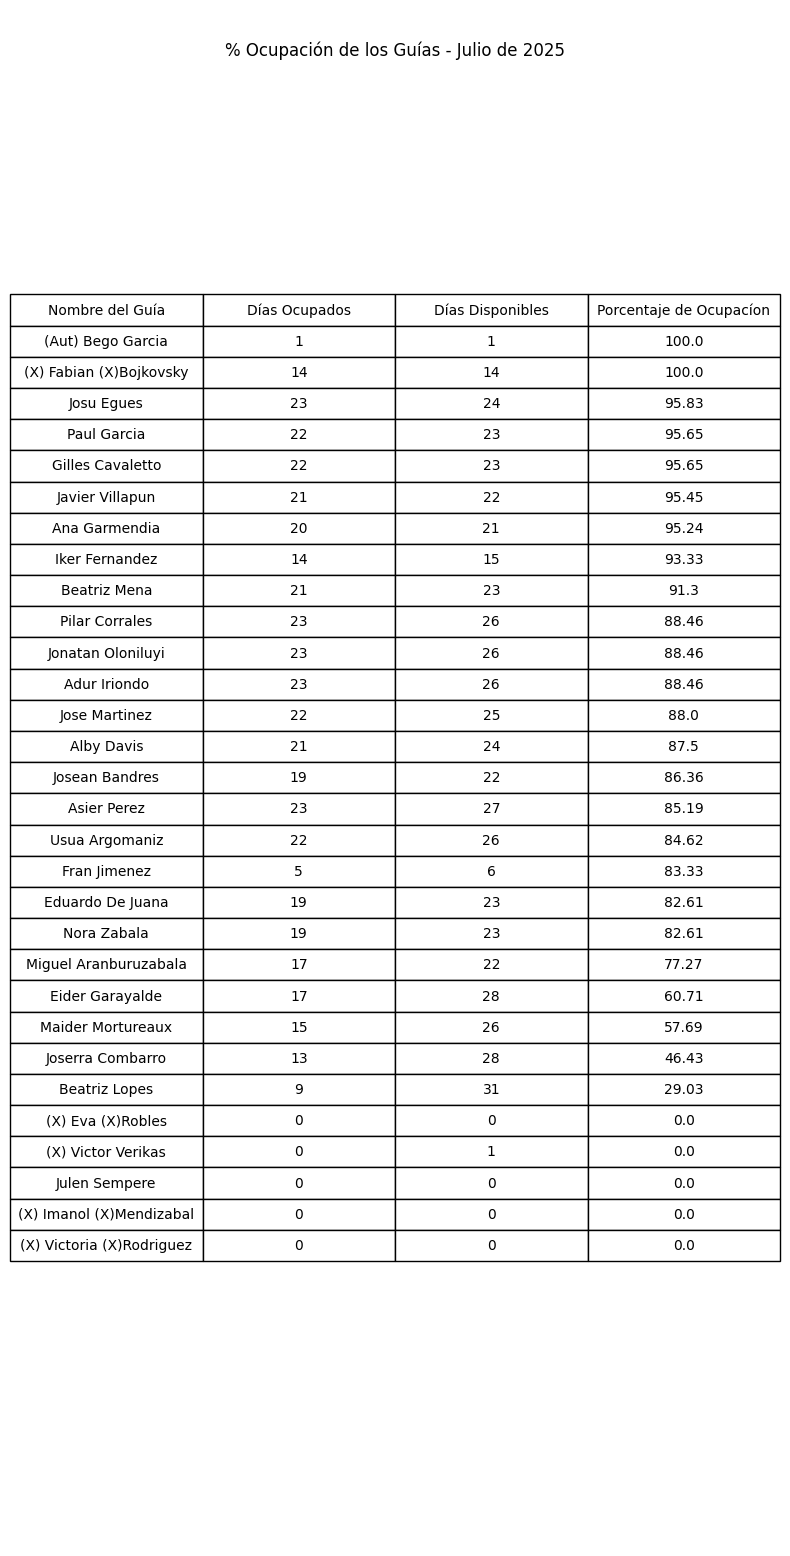

In [439]:
# --- INSIGHT 8.5: Calculate Occupancy Rate for July 2025 ---
# Occupancy Rate = (DaysOccupied / AvailableDays) * 100


# Convert to Series indexed by GuideName
occupied_days_series_07_2025 = occupied_days_07_2025.set_index("GuideName")["DaysOccupied"]
available_days_series = available_days_per_guide_07.set_index("GuideName")["DaysAvailable"]

# Combine into one DataFrame
stats = pd.DataFrame(
    {
        "DaysOccupied": occupied_days_series_07_2025,
        "AvailableDays": available_days_series,
    }
)
# Compute Occupancy %
stats["OccupancyPct"] = (stats["DaysOccupied"] / stats["AvailableDays"] * 100).round(2)

# Handle division by 0 (optional: set to 0 or NaN as needed)
stats["OccupancyPct"] = stats["OccupancyPct"].fillna(0)

# Sort by occupancy rate descending
stats_sorted_07_2025 = stats.sort_values(["OccupancyPct"], ascending=False)

# Reset index for tabular plotting
occupancy_table_07_2025 = stats_sorted_07_2025.reset_index(names="GuideName")[
    ["GuideName", "DaysOccupied", "AvailableDays", "OccupancyPct"]
]

# --- Plot the table ---
translated_labels = [
    "Nombre del Guía",
    "Días Ocupados",
    "Días Disponibles",
    "Porcentaje de Ocupacíon",
]

fig, ax = plt.subplots(figsize=(8, len(occupancy_table_07_2025) * 0.5 + 1))
ax.axis("off")  # Hide axes

# Create the table
tbl = ax.table(
    cellText=occupancy_table_07_2025.values,
    colLabels=translated_labels,
    cellLoc="center",
    loc="center",
)

# Styling
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Title and layout
plt.suptitle(f'% Ocupación de los Guías - {MONTHS["07"]}', y=0.95, fontsize=12)
plt.tight_layout()
plt.show()

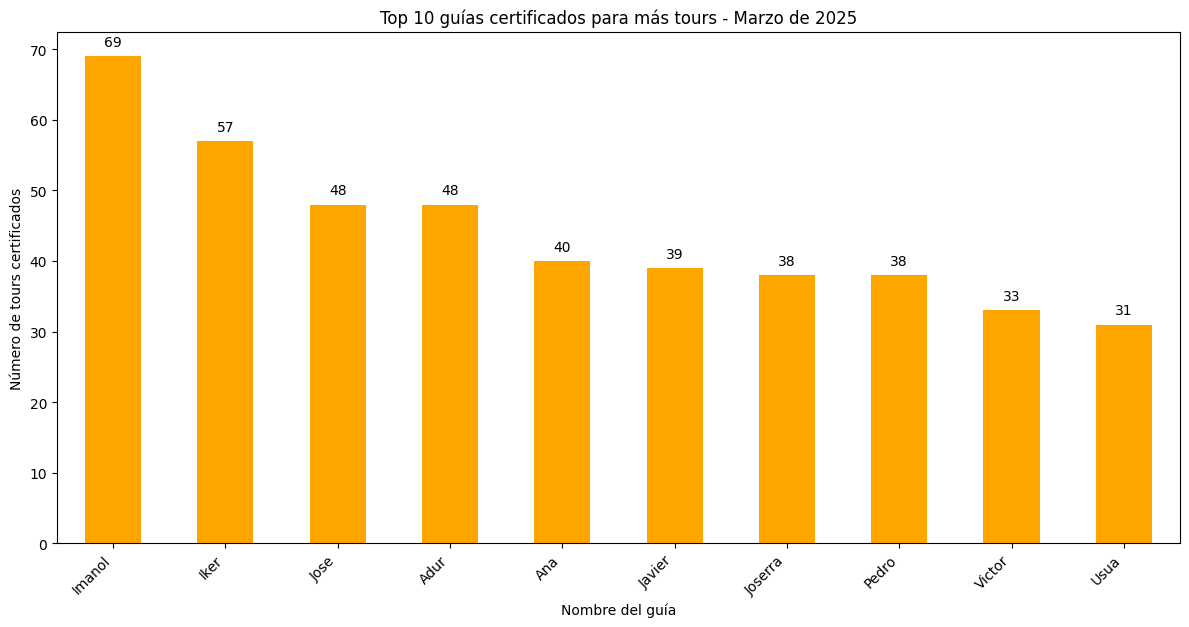

In [440]:
# INSIGHT 9.1: Guides Certified for the Most Tours – March 2025

# Count how many tours each guide is certified for

top_skilled_guides_03_2025 = skills_named["03"]["GuideName"].value_counts().head(10)

# Plot and capture the axes object
ax = top_skilled_guides_03_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["03"]]
)  # store the ax

# Add value labels
for i, value in enumerate(top_skilled_guides_03_2025.values):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Add title and axis labels
ax.set_title(f'Top 10 guías certificados para más tours - {MONTHS["03"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de tours certificados")

# Rotate x-axis labels
ax.set_xticks(range(len(top_skilled_guides_03_2025)))
ax.set_xticklabels(top_skilled_guides_03_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

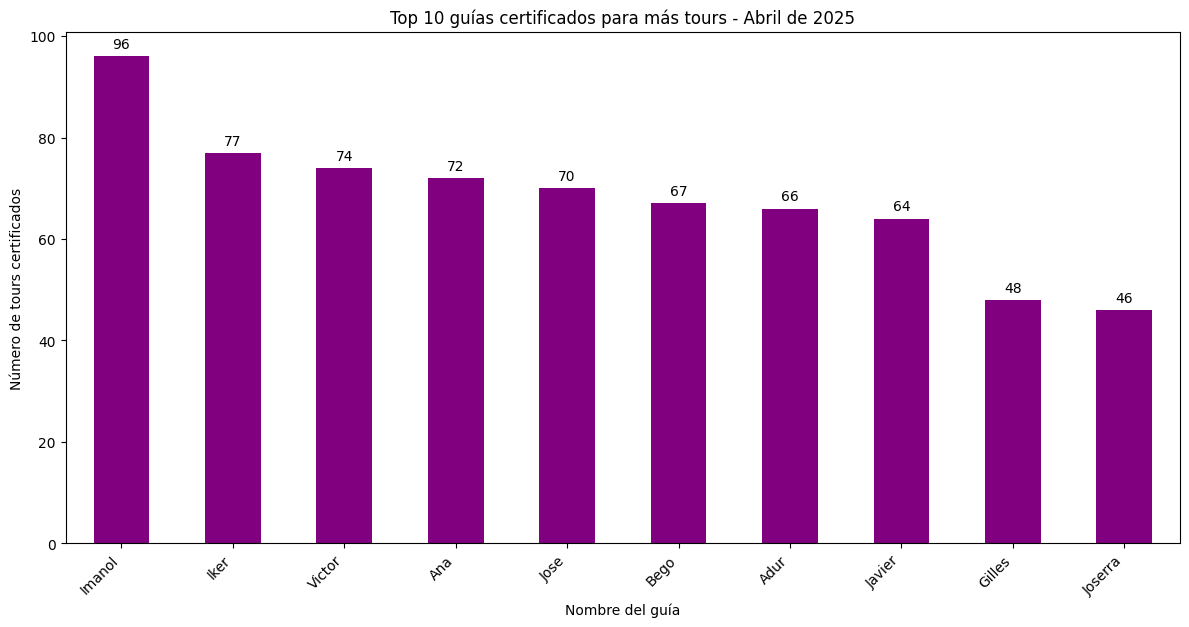

In [441]:
# INSIGHT 9.2: Guides certified for the most tours for April 2025

# Count how many tours each guide is certified for
top_skilled_guides_04_2025 = skills_named["04"]["GuideName"].value_counts().head(10)

# Plot and capture the axes object
ax = top_skilled_guides_04_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["04"]]
)

# Add value labels
for i, value in enumerate(top_skilled_guides_04_2025.values):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Add title and axis labels
ax.set_title(f'Top 10 guías certificados para más tours - {MONTHS["04"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de tours certificados")

# Rotate x-axis labels
ax.set_xticks(range(len(top_skilled_guides_04_2025)))
ax.set_xticklabels(top_skilled_guides_04_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

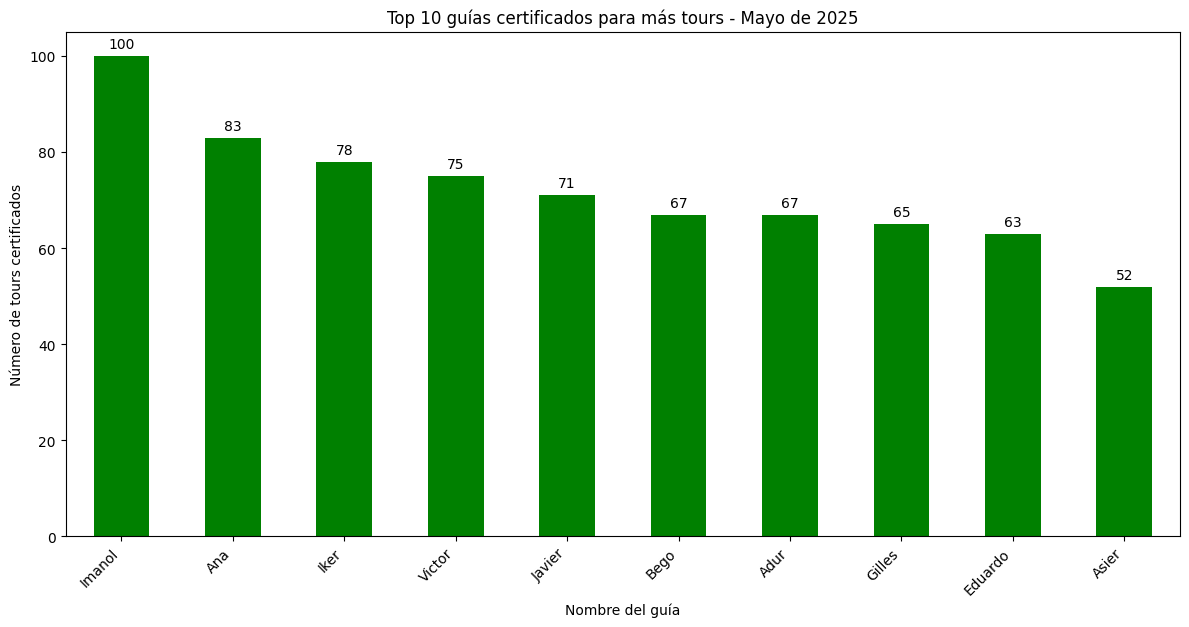

In [442]:
# INSIGHT 9.3: Guides Certified for the Most Tours – May 2025

# Count how many tours each guide is certified for
top_skilled_guides_05_2025 = skills_named["05"]["GuideName"].value_counts().head(10)

# Plot and capture the axes object
ax = top_skilled_guides_05_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["05"]]
)

# Add value labels
for i, value in enumerate(top_skilled_guides_05_2025.values):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Add title and axis labels
ax.set_title(f'Top 10 guías certificados para más tours - {MONTHS["05"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de tours certificados")

# Rotate x-axis labels
ax.set_xticks(range(len(top_skilled_guides_05_2025)))
ax.set_xticklabels(top_skilled_guides_05_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

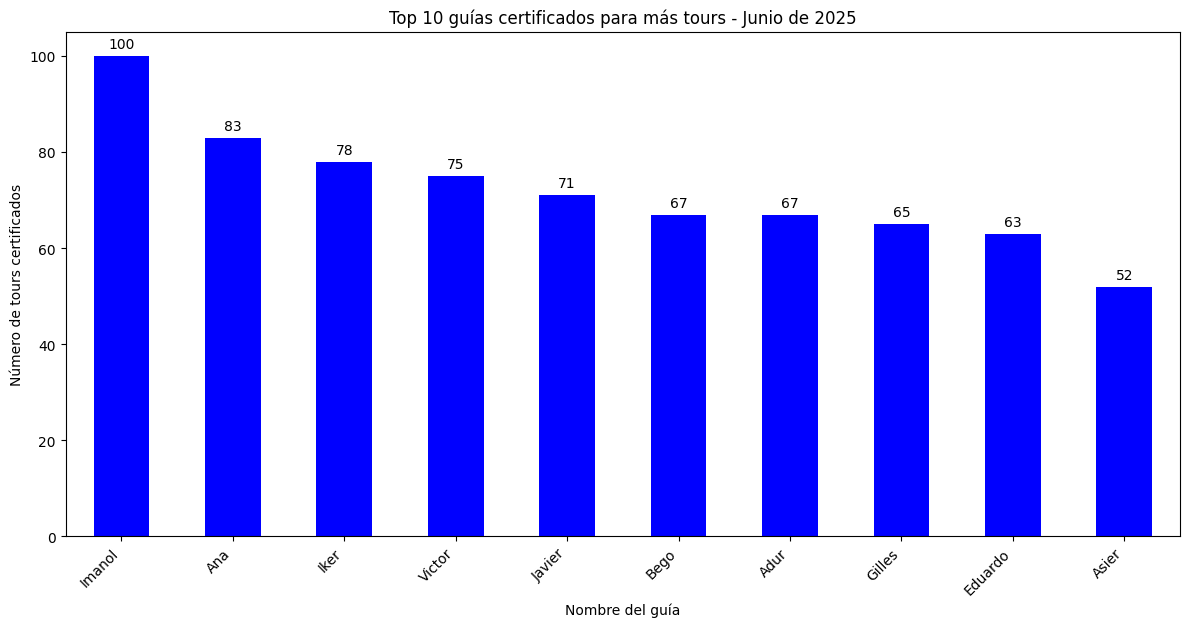

In [443]:
# INSIGHT 9.4: Guides Certified for the Most Tours – June 2025

# Count how many tours each guide is certified for
top_skilled_guides_06_2025 = skills_named["06"]["GuideName"].value_counts().head(10)

# Plot and capture the axes object
ax = top_skilled_guides_06_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["06"]]
)

# Add value labels
for i, value in enumerate(top_skilled_guides_06_2025.values):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Add title and axis labels
ax.set_title(f'Top 10 guías certificados para más tours - {MONTHS["06"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de tours certificados")

# Rotate x-axis labels
ax.set_xticks(range(len(top_skilled_guides_06_2025)))
ax.set_xticklabels(top_skilled_guides_06_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

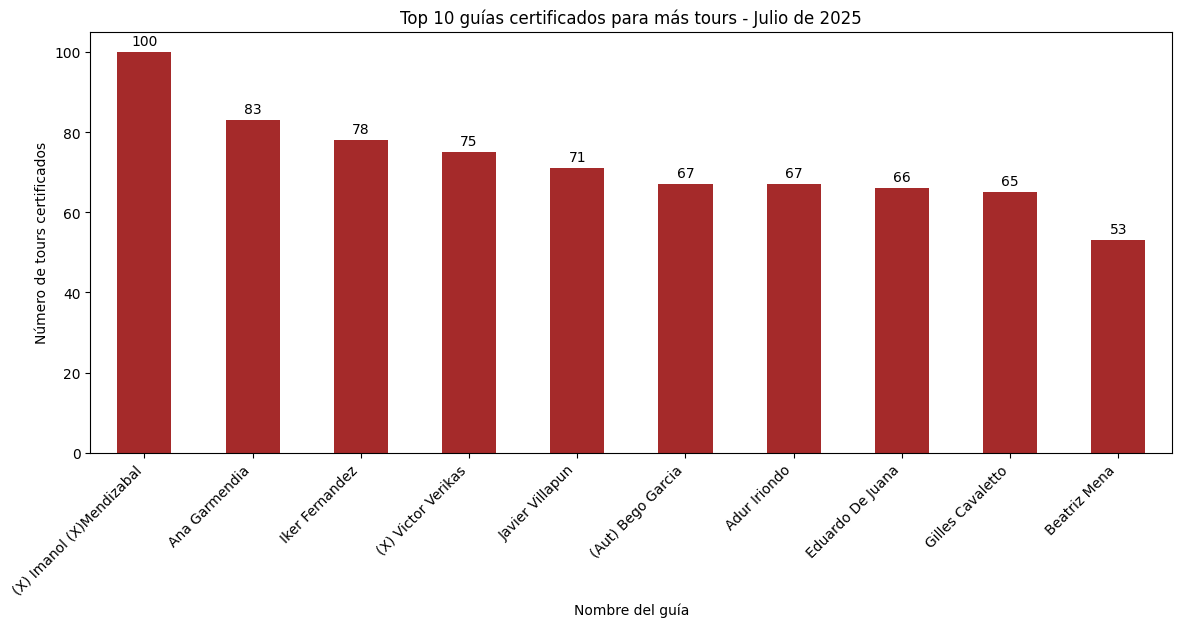

In [444]:
# INSIGHT 9.5: Guides Certified for the Most Tours – July 2025

# Count how many tours each guide is certified for
top_skilled_guides_07_2025 = skills_named["07"]["GuideName"].value_counts().head(10)

# Plot and capture the axes object
ax = top_skilled_guides_07_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["07"]]
)

# Add value labels
for i, value in enumerate(top_skilled_guides_07_2025.values):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Add title and axis labels
ax.set_title(f'Top 10 guías certificados para más tours - {MONTHS["07"]}')
ax.set_xlabel("Nombre del guía")
ax.set_ylabel("Número de tours certificados")

# Rotate x-axis labels
ax.set_xticks(range(len(top_skilled_guides_07_2025)))
ax.set_xticklabels(top_skilled_guides_07_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

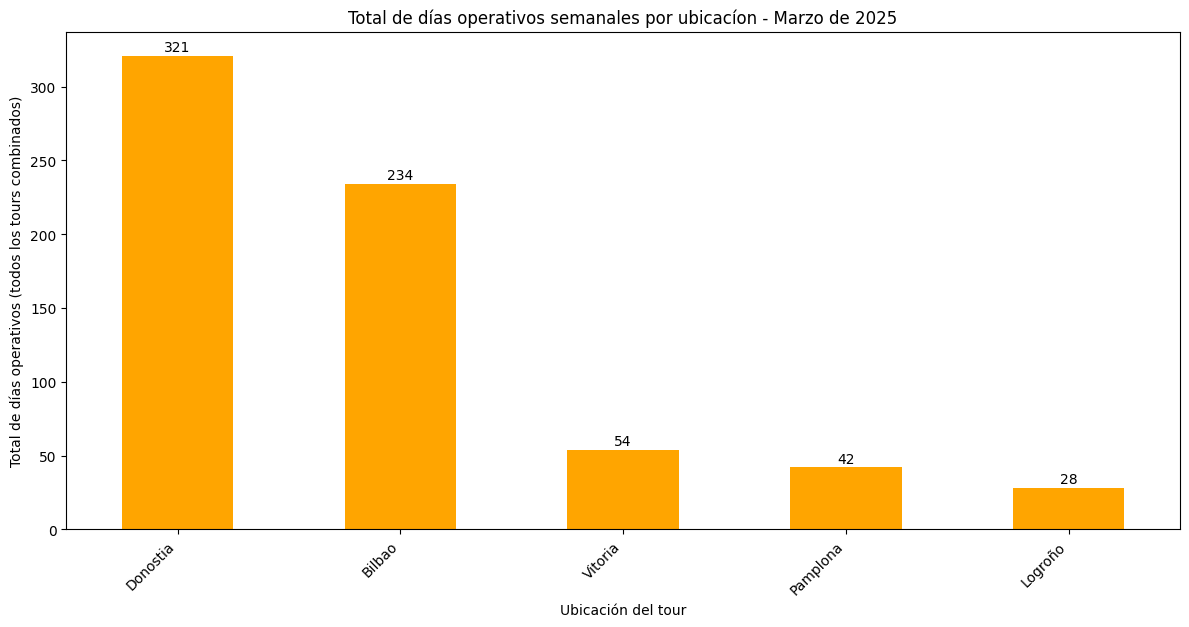

In [445]:
# INSIGHT 10.1: Total Operating Days by Location – March 2025

# Extract March tours from the dictionary
tours_03_2025 = tours["03"]

# Column indicating operation on days of the week
week_cols = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]

# Create a column for total operating days per tour
tours_03_2025["Tours_Operating_Days"] = tours_03_2025[week_cols].sum(axis=1)

# Group by location and sum total operating days per tour
location_totals_03_2025 = (
    tours_03_2025.groupby("TourLocation")["Tours_Operating_Days"]
    .sum()
    .sort_values(ascending=False)
)

# Plot and capture the axes object
ax = location_totals_03_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["03"]]
)  # store the ax

# Add value labels
for i, value in enumerate(location_totals_03_2025):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Total de días operativos semanales por ubicacíon - {MONTHS["03"]}')
ax.set_xlabel("Ubicación del tour")
ax.set_ylabel("Total de días operativos (todos los tours combinados)")

# Rotate x-axis labels
ax.set_xticks(range(len(location_totals_03_2025)))
ax.set_xticklabels(location_totals_03_2025.index, rotation=45, ha="right")
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

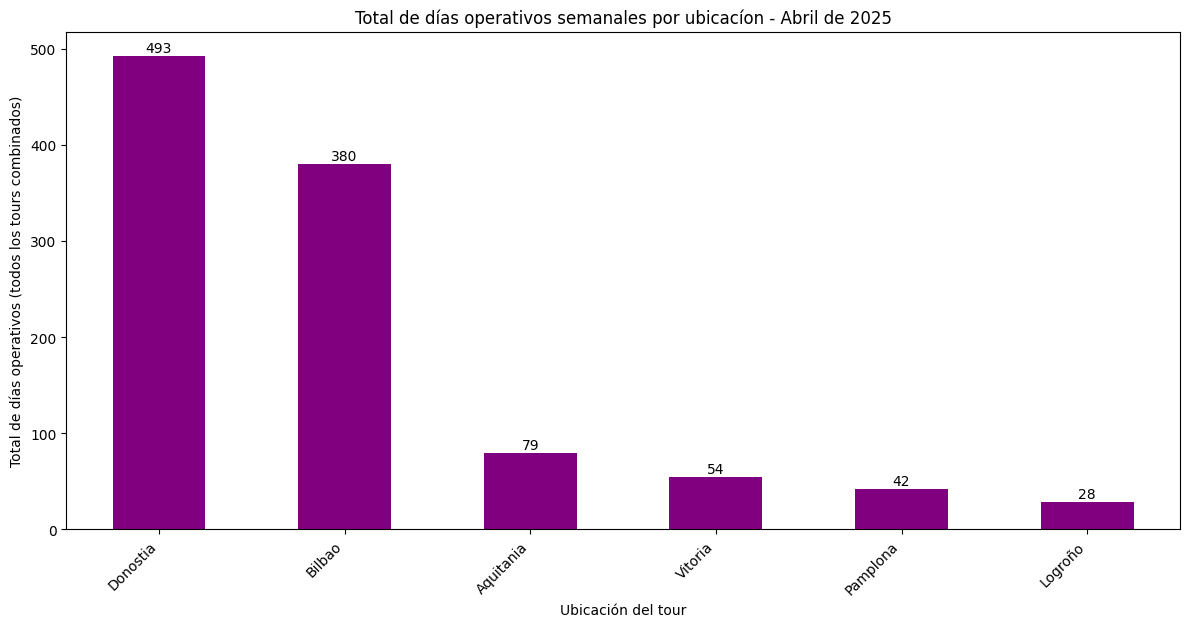

In [446]:
# INSIGHT 10.2: Total Operating Days by Location – April 2025

# Extract April tours from the dictionary
tours_04_2025 = tours["04"]

# Column indicating operation on days of the week
week_cols = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]

# Create a column for total operating days per tour
tours_04_2025["Tours_Operating_Days"] = tours_04_2025[week_cols].sum(axis=1)

# Group by location and sum total operating days
location_totals_04_2025 = (
    tours_04_2025.groupby("TourLocation")["Tours_Operating_Days"]
    .sum()
    .sort_values(ascending=False)
)

# Plot and capture the axes object
ax = location_totals_04_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["04"]]
)

# Add value labels
for i, value in enumerate(location_totals_04_2025):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Total de días operativos semanales por ubicacíon - {MONTHS["04"]}')
ax.set_xlabel("Ubicación del tour")
ax.set_ylabel("Total de días operativos (todos los tours combinados)")

# Rotate x-axis labels
ax.set_xticks(range(len(location_totals_04_2025)))
ax.set_xticklabels(location_totals_04_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

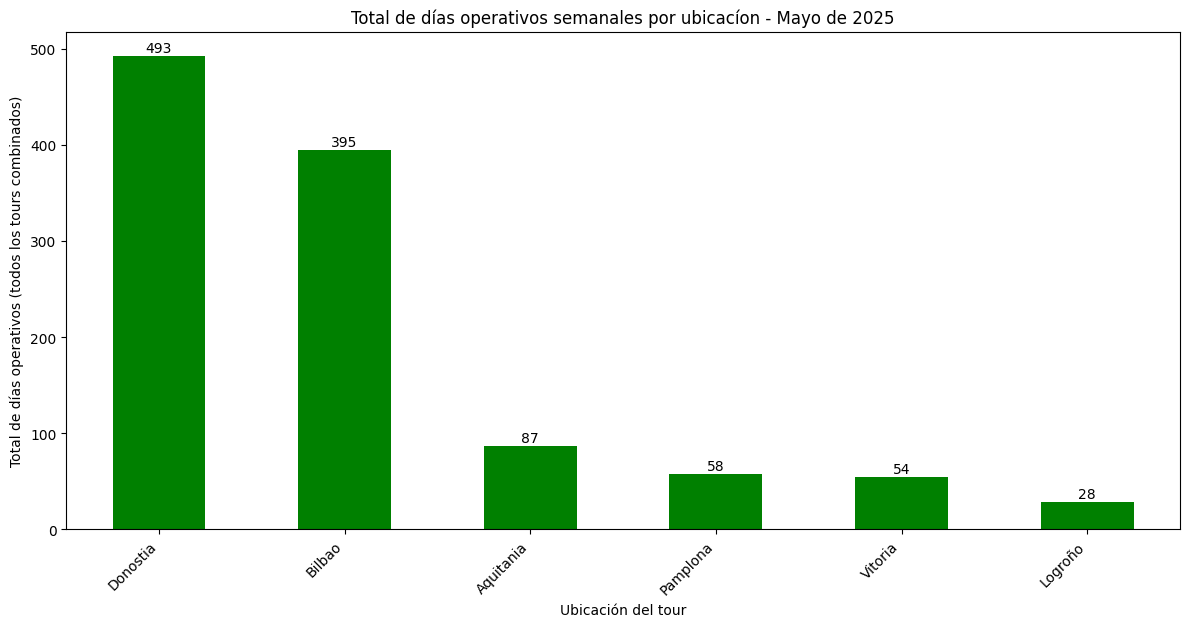

In [447]:
# INSIGHT 10.3: Total Operating Days by Location – May 2025

# Extract May tours from the dictionary
tours_05_2025 = tours["05"]

# Column indicating operation on days of the week
week_cols = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]

# Create a column for total operating days per tour
tours_05_2025["Tours_Operating_Days"] = tours_05_2025[week_cols].sum(axis=1)

# Group by location and sum total operating days
location_totals_05_2025 = (
    tours_05_2025.groupby("TourLocation")["Tours_Operating_Days"]
    .sum()
    .sort_values(ascending=False)
)

# Plot and capture the axes object
ax = location_totals_05_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["05"]]
)

# Add value labels
for i, value in enumerate(location_totals_05_2025):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Total de días operativos semanales por ubicacíon - {MONTHS["05"]}')
ax.set_xlabel("Ubicación del tour")
ax.set_ylabel("Total de días operativos (todos los tours combinados)")

# Rotate x-axis labels
ax.set_xticks(range(len(location_totals_05_2025)))
ax.set_xticklabels(location_totals_05_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

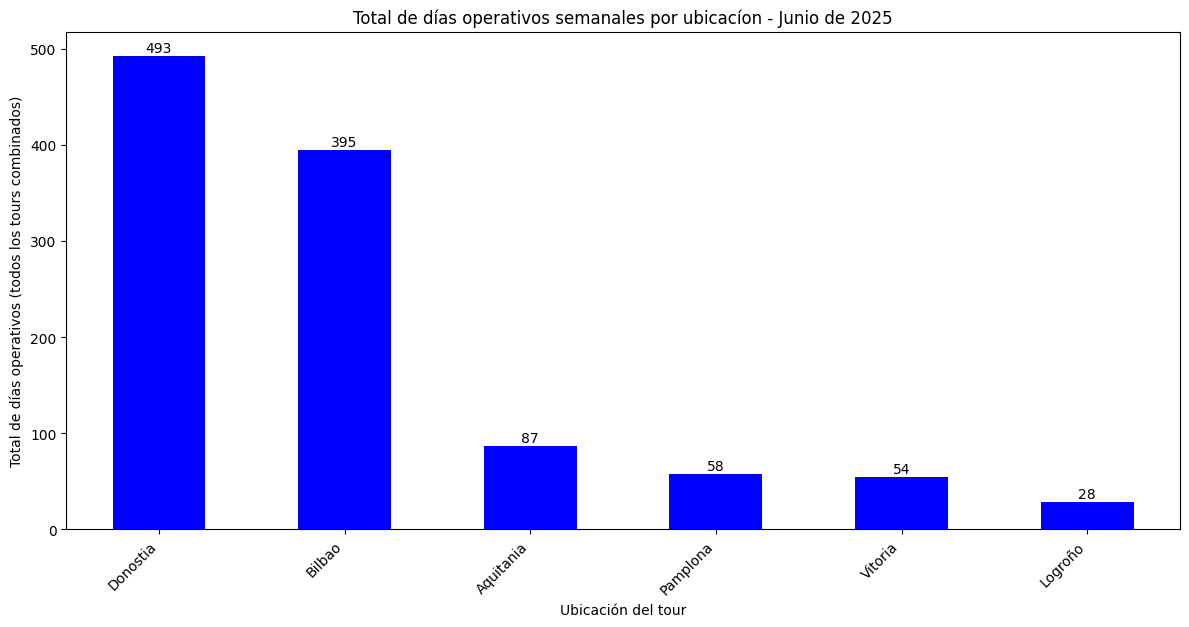

In [448]:
# INSIGHT 10.4: Total Operating Days by Location – June 2025

# Extract June tours from the dictionary
tours_06_2025 = tours["06"]

# Column indicating operation on days of the week
week_cols = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]

# Create a column for total operating days per tour
tours_06_2025["Tours_Operating_Days"] = tours_06_2025[week_cols].sum(axis=1)

# Group by location and sum total operating days per tour
location_totals_06_2025 = (
    tours_06_2025.groupby("TourLocation")["Tours_Operating_Days"]
    .sum()
    .sort_values(ascending=False)
)

# Plot and capture the axes object
ax = location_totals_06_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["06"]]
)  # store the ax

# Add value labels
for i, value in enumerate(location_totals_06_2025):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Total de días operativos semanales por ubicacíon - {MONTHS["06"]}')
ax.set_xlabel("Ubicación del tour")
ax.set_ylabel("Total de días operativos (todos los tours combinados)")

# Rotate x-axis labels
ax.set_xticks(range(len(location_totals_06_2025)))
ax.set_xticklabels(location_totals_06_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

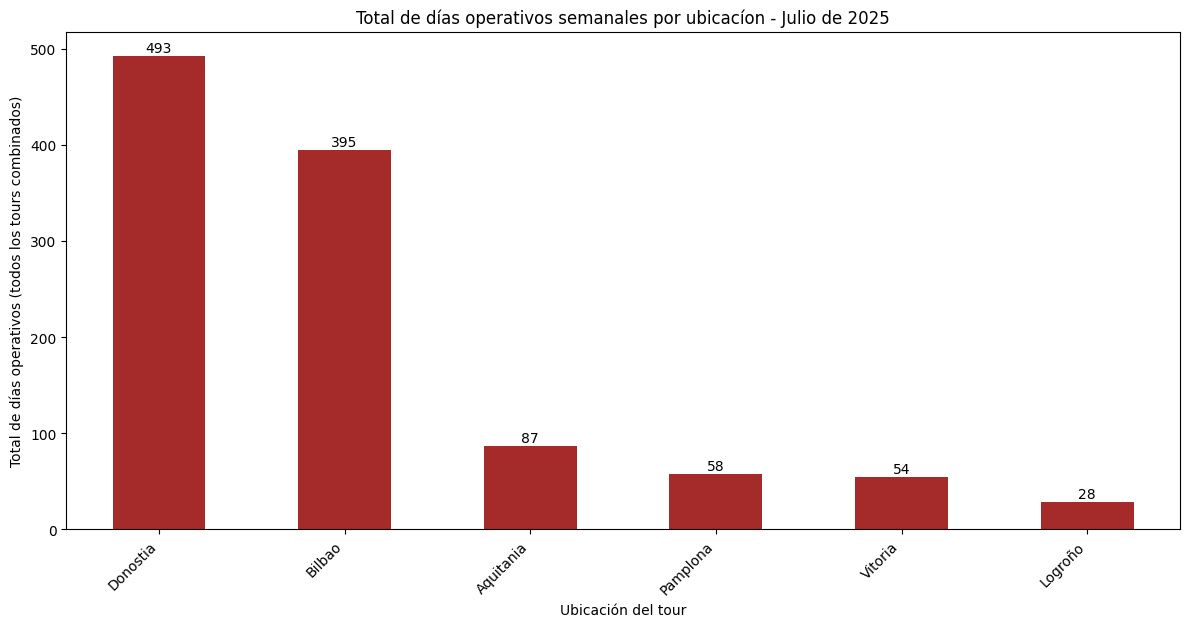

In [449]:
# INSIGHT 10.5: Total Operating Days by Location – July 2025

# Extract July tours from the dictionary
tours_07_2025 = tours["07"]

# Column indicating operation on days of the week
week_cols = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]

# Create a column for total operating days per tour
tours_07_2025["Tours_Operating_Days"] = tours_07_2025[week_cols].sum(axis=1)

# Group by location and sum total operating days per tour
location_totals_07_2025 = (
    tours_07_2025.groupby("TourLocation")["Tours_Operating_Days"]
    .sum()
    .sort_values(ascending=False)
)

# Plot and capture the axes object
ax = location_totals_07_2025.plot(
    kind="bar", figsize=DEFAULT_FIGSIZE, color=[BAR_COLORS["07"]]
)  # store the ax

# Add value labels
for i, value in enumerate(location_totals_07_2025):
    ax.text(
        i, value + 1, str(value), ha="center", va="bottom", fontsize=LABEL_FONT_SIZE
    )

# Title and axis labels
ax.set_title(f'Total de días operativos semanales por ubicacíon - {MONTHS["07"]}')
ax.set_xlabel("Ubicación del tour")
ax.set_ylabel("Total de días operativos (todos los tours combinados)")

# Rotate x-axis labels
ax.set_xticks(range(len(location_totals_07_2025)))
ax.set_xticklabels(location_totals_07_2025.index, rotation=45, ha="right")

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

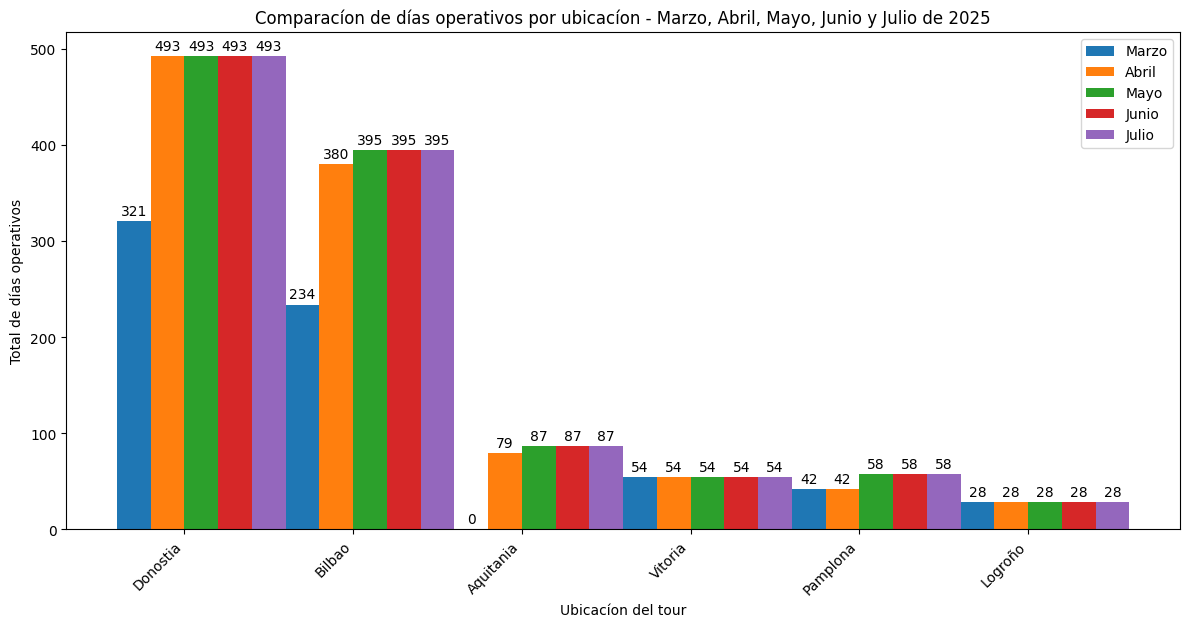

In [450]:
# INSIGHT 10.6: Compare Operating Days by Location – March to July 2025

# Step 1: Convert Series to DataFrames and reset index
# March
location_days_03_df = location_totals_03_2025.reset_index()
location_days_03_df.columns = ["TourLocation", "OperatingDays_March"]
# April
location_days_04_df = location_totals_04_2025.reset_index()
location_days_04_df.columns = ["TourLocation", "OperatingDays_April"]
# May
location_days_05_df = location_totals_05_2025.reset_index()
location_days_05_df.columns = ["TourLocation", "OperatingDays_May"]
# June
location_days_06_df = location_totals_06_2025.reset_index()
location_days_06_df.columns = ["TourLocation", "OperatingDays_June"]
# July
location_days_07_df = location_totals_07_2025.reset_index()
location_days_07_df.columns = ["TourLocation", "OperatingDays_July"]

# Step 2: Merge all months' data
location_days_combined = pd.merge(
            pd.merge(
                pd.merge(
                    pd.merge(
                        location_days_03_df, location_days_04_df, on="TourLocation", how="outer"
                    ),
                    location_days_05_df,
                    on="TourLocation",
                    how="outer",
                ),
                location_days_06_df,
                on="TourLocation",
                how="outer",
            ),
            location_days_07_df,
            on="TourLocation",
            how="outer",
).fillna(0)

# Convert columns to integers
location_days_combined["OperatingDays_March"] = location_days_combined[
    "OperatingDays_March"
].astype(int)
location_days_combined["OperatingDays_April"] = location_days_combined[
    "OperatingDays_April"
].astype(int)
location_days_combined["OperatingDays_May"] = location_days_combined[
    "OperatingDays_May"
].astype(int)
location_days_combined["OperatingDays_June"] = location_days_combined[
    "OperatingDays_June"
].astype(int)
location_days_combined["OperatingDays_July"] = location_days_combined[
    "OperatingDays_July"
].astype(int)

# Calculate total and sort
location_days_combined["Total"] = (
    location_days_combined["OperatingDays_March"]
    + location_days_combined["OperatingDays_April"]
    + location_days_combined["OperatingDays_May"]
    + location_days_combined["OperatingDays_June"]
    + location_days_combined["OperatingDays_July"]
)
location_days_combined = location_days_combined.sort_values(by="Total", ascending=False)

# Step 3: Plot grouped bars
x = range(len(location_days_combined))
bar_width = 0.2
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Month colors
# March
ax.bar(
    [i - 1.5 * bar_width for i in x],
    location_days_combined["OperatingDays_March"],
    width=bar_width,
    label="Marzo",
)

# April
ax.bar(
    [i - 0.5 * bar_width for i in x],
    location_days_combined["OperatingDays_April"],
    width=bar_width,
    label="Abril",
)
# May
ax.bar(
    [i + 0.5 * bar_width for i in x],
    location_days_combined["OperatingDays_May"],
    width=bar_width,
    label="Mayo",
)
# June
ax.bar(
    [i + 1.5 * bar_width for i in x],
    location_days_combined["OperatingDays_June"],
    width=bar_width,
    label="Junio",
)
#July
ax.bar(
    [i + 2.5 * bar_width for i in x],
    location_days_combined["OperatingDays_July"],
    width=bar_width,
    label="Julio",
)

# Value labels
for i, row in enumerate(location_days_combined.itertuples()):
    ax.text(
        i - 1.5 * bar_width,
        row.OperatingDays_March + 3,
        str(row.OperatingDays_March),
        ha="center",
        va="bottom",
        fontsize=LABEL_FONT_SIZE,
    )
    ax.text(
        i - 0.5 * bar_width,
        row.OperatingDays_April + 3,
        str(row.OperatingDays_April),
        ha="center",
        va="bottom",
        fontsize=LABEL_FONT_SIZE,
    )
    ax.text(
        i + 0.5 * bar_width,
        row.OperatingDays_May + 3,
        str(row.OperatingDays_May),
        ha="center",
        va="bottom",
        fontsize=LABEL_FONT_SIZE,
    )
    ax.text(
        i + 1.5 * bar_width,
        row.OperatingDays_June + 3,
        str(row.OperatingDays_June),
        ha="center",
        va="bottom",
        fontsize=LABEL_FONT_SIZE,
    )
    ax.text(
        i + 2.5 * bar_width,
        row.OperatingDays_July + 3,
        str(row.OperatingDays_July),
        ha="center",
        va="bottom",
        fontsize=LABEL_FONT_SIZE,
    )

# Clean up label formatting
tours_labels = [label.strip("'") for label in location_days_combined["TourLocation"]]

# Axis labels
ax.set_title(
    f"Comparacíon de días operativos por ubicacíon - Marzo, Abril, Mayo, Junio y Julio de 2025"
)
ax.set_xlabel("Ubicacíon del tour")
ax.set_ylabel("Total de días operativos")
ax.set_xticks(list(x))
ax.set_xticklabels(tours_labels, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

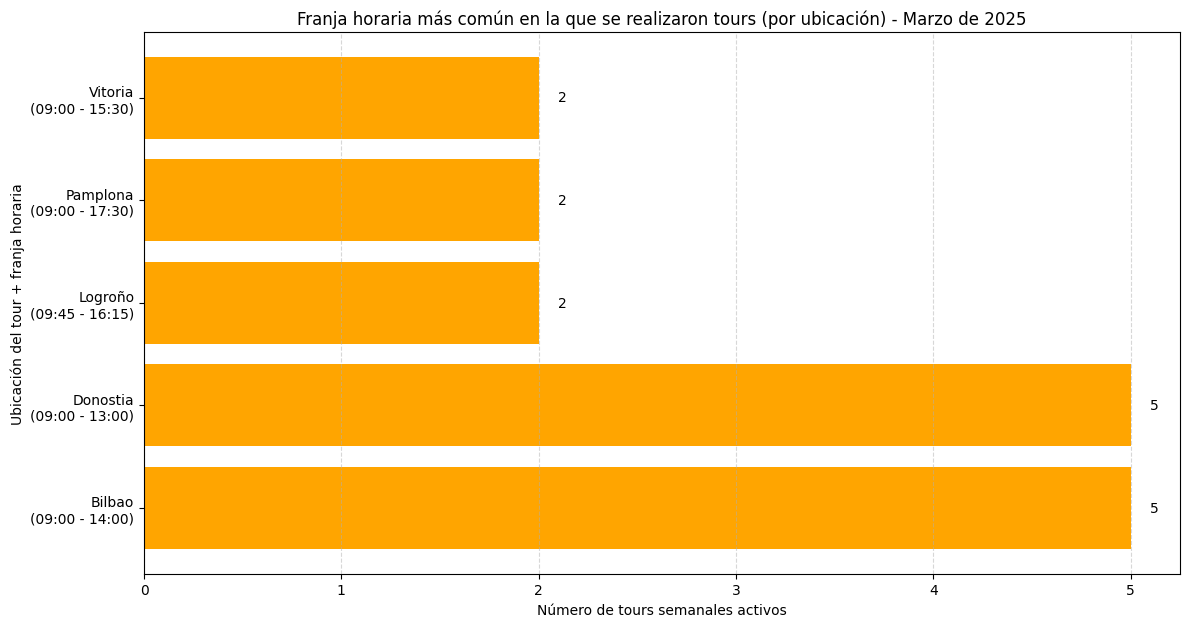

In [451]:
# INSIGHT 11.1: Most Common Time Slot per Location – March 2025

# Construct TimeSlot string
tours_03_2025["TimeSlot"] = (
    tours_03_2025["TimeStart"].astype(str)
    + " - "
    + tours_03_2025["TimeEnd"].astype(str)
)

# Calculate operating days per tour
op_cols_03_2025 = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]
tours_03_2025["Tours_Operating_Days"] = tours_03_2025[op_cols_03_2025].sum(
    axis=1
)  # it tells how many days a tour actually runs

# Filter only active tours
active_tours_03_2025 = tours_03_2025[tours_03_2025["Tours_Operating_Days"] > 0]

# Count time slots per location
slot_counts_03_2025 = (
    active_tours_03_2025.groupby(["TourLocation", "TimeSlot"])
    .size()
    .reset_index(name="Count")
)

# Select the most common time slot per location
top_slot_03_2025 = slot_counts_03_2025.sort_values(
    "Count", ascending=False
).drop_duplicates(subset=["TourLocation"], keep="first")

# Label for plotting (Location + Time Slot)
top_slot_03_2025["Label"] = (
    top_slot_03_2025["TourLocation"] + "\n(" + top_slot_03_2025["TimeSlot"] + ")"
)

# Plot horizontal bar chart
plt.figure(figsize=DEFAULT_FIGSIZE)
bars = plt.barh(
    top_slot_03_2025["Label"], top_slot_03_2025["Count"], color=BAR_COLORS["03"]
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.1, y_pos, str(int(width)), va="center", fontsize=LABEL_FONT_SIZE)

# Styling
plt.xlabel("Número de tours semanales activos")
plt.ylabel("Ubicación del tour + franja horaria")
plt.title(
    f'Franja horaria más común en la que se realizaron tours (por ubicación) - {MONTHS["03"]}'
)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Adjust layout
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

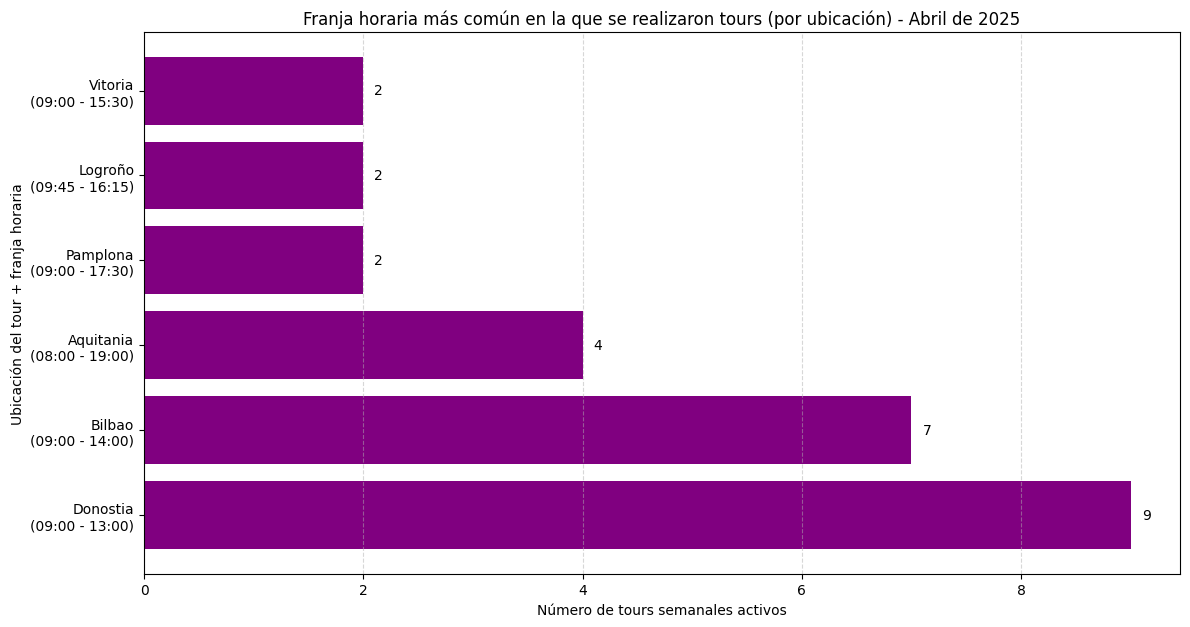

In [452]:
# INSIGHT 11.2: Most Common Time Slot per Location – April 2025

# Construct TimeSlot string
tours_04_2025["TimeSlot"] = (
    tours_04_2025["TimeStart"].astype(str)
    + " - "
    + tours_04_2025["TimeEnd"].astype(str)
)

# Calculate operating days per tour
op_cols_04_2025 = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]
tours_04_2025["Tours_Operating_Days"] = tours_04_2025[op_cols_04_2025].sum(
    axis=1
)  # it tells how many days a tour actually runs

# Filter only active tours
active_tours_04_2025 = tours_04_2025[tours_04_2025["Tours_Operating_Days"] > 0]

# Count time slots per location
slot_counts_04_2025 = (
    active_tours_04_2025.groupby(["TourLocation", "TimeSlot"])
    .size()
    .reset_index(name="Count")
)

# Select the most common time slot per location
top_slot_04_2025 = slot_counts_04_2025.sort_values(
    "Count", ascending=False
).drop_duplicates(subset=["TourLocation"], keep="first")

# Label for plotting (Location + Time Slot)
top_slot_04_2025["Label"] = (
    top_slot_04_2025["TourLocation"] + "\n(" + top_slot_04_2025["TimeSlot"] + ")"
)

# Plot horizontal bar chart
plt.figure(figsize=DEFAULT_FIGSIZE)
bars = plt.barh(
    top_slot_04_2025["Label"], top_slot_04_2025["Count"], color=BAR_COLORS["04"]
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.1, y_pos, str(int(width)), va="center", fontsize=LABEL_FONT_SIZE)

# Styling
plt.xlabel("Número de tours semanales activos")
plt.ylabel("Ubicación del tour + franja horaria")
plt.title(
    f'Franja horaria más común en la que se realizaron tours (por ubicación) - {MONTHS["04"]}'
)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Layout adjustments
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

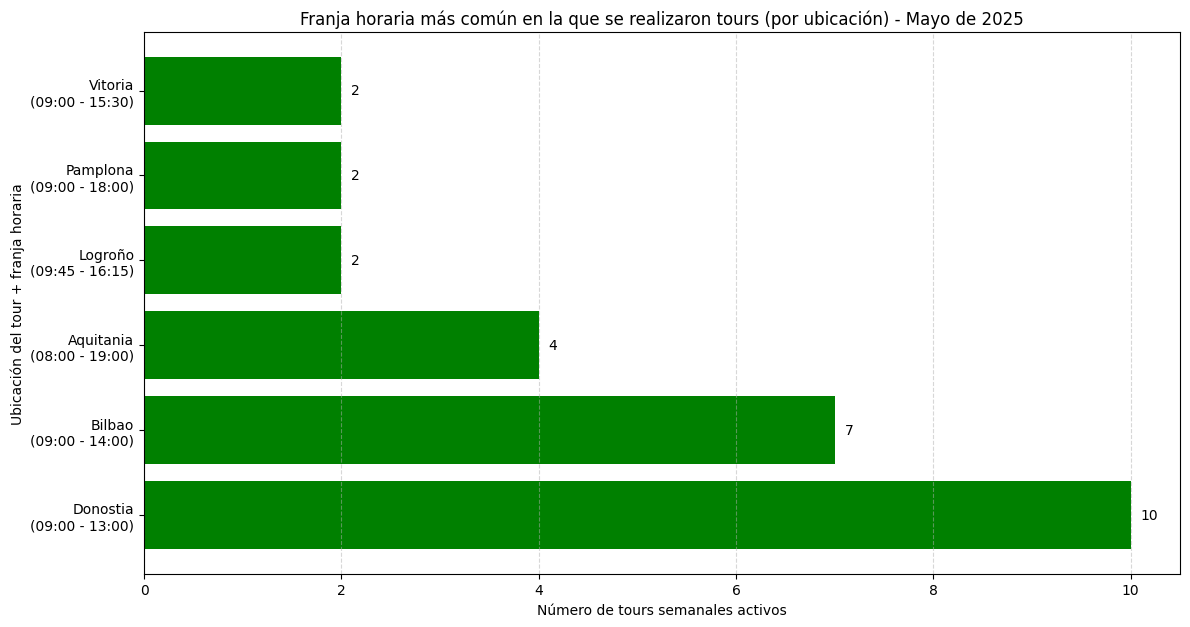

In [453]:
# --- INSIGHT 11.3: Most Common Time Slot per Location – May 2025 ---

# Construct TimeSlot string
tours_05_2025["TimeSlot"] = (
    tours_05_2025["TimeStart"].astype(str)
    + " - "
    + tours_05_2025["TimeEnd"].astype(str)
)

# Calculate operating days per tour
op_cols_05_2025 = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]
tours_05_2025["Tours_Operating_Days"] = tours_05_2025[op_cols_05_2025].sum(axis=1)

# Filter only active tours
active_tours_05_2025 = tours_05_2025[tours_05_2025["Tours_Operating_Days"] > 0]

# Count time slot per location
slot_counts_05_2025 = (
    active_tours_05_2025.groupby(["TourLocation", "TimeSlot"])
    .size()
    .reset_index(name="Count")
)

# Select the most common time slot per location
top_slot_05_2025 = slot_counts_05_2025.sort_values(
    "Count", ascending=False
).drop_duplicates(subset=["TourLocation"], keep="first")

# Label for plotting (Location + Time Slot)
top_slot_05_2025["Label"] = (
    top_slot_05_2025["TourLocation"] + "\n(" + top_slot_05_2025["TimeSlot"] + ")"
)

# Plot horizontal bar chart
plt.figure(figsize=DEFAULT_FIGSIZE)
bars = plt.barh(
    top_slot_05_2025["Label"], top_slot_05_2025["Count"], color=BAR_COLORS["05"]
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.1, y_pos, str(int(width)), va="center", fontsize=LABEL_FONT_SIZE)

# Styling
plt.xlabel("Número de tours semanales activos")
plt.ylabel("Ubicación del tour + franja horaria")
plt.title(
    f'Franja horaria más común en la que se realizaron tours (por ubicación) - {MONTHS["05"]}'
)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Layout adjustments
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

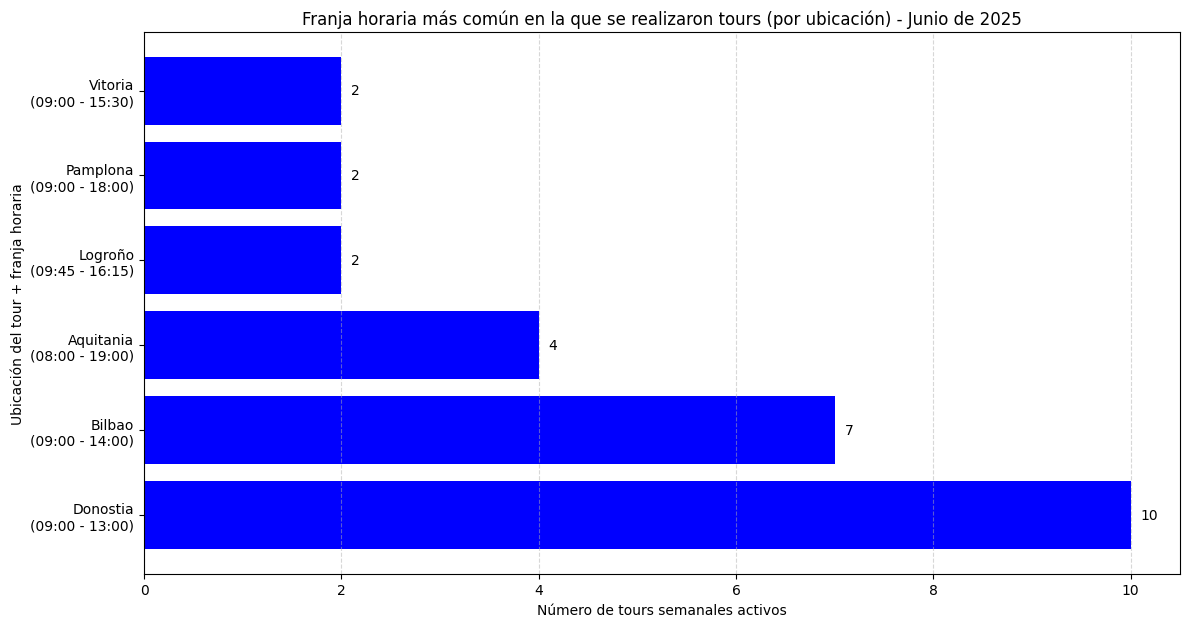

In [454]:
# --- INSIGHT 11.4: Most Common Time Slot per Location – June 2025 ---

# Construct TimeSlot string
tours_06_2025["TimeSlot"] = (
    tours_06_2025["TimeStart"].astype(str)
    + " - "
    + tours_06_2025["TimeEnd"].astype(str)
)

# Calculate operating days per tour
op_cols_06_2025 = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]
tours_06_2025["Tours_Operating_Days"] = tours_06_2025[op_cols_06_2025].sum(
    axis=1
)  # it tells how many days a tour actually runs

# Filter only active tours
active_tours_06_2025 = tours_06_2025[tours_06_2025["Tours_Operating_Days"] > 0]

# Count time slot per location
slot_counts_06_2025 = (
    active_tours_06_2025.groupby(["TourLocation", "TimeSlot"])
    .size()
    .reset_index(name="Count")
)

# Select the most common time slot per location
top_slot_06_2025 = slot_counts_06_2025.sort_values(
    "Count", ascending=False
).drop_duplicates(subset=["TourLocation"], keep="first")

# Label for plotting (Location + Time Slot)
top_slot_06_2025["Label"] = (
    top_slot_06_2025["TourLocation"] + "\n(" + top_slot_06_2025["TimeSlot"] + ")"
)

# Plot horizontal bar chart
plt.figure(figsize=DEFAULT_FIGSIZE)
bars = plt.barh(
    top_slot_06_2025["Label"], top_slot_06_2025["Count"], color=BAR_COLORS["06"]
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.1, y_pos, str(int(width)), va="center", fontsize=LABEL_FONT_SIZE)

# Styling
plt.xlabel("Número de tours semanales activos")
plt.ylabel("Ubicación del tour + franja horaria")
plt.title(
    f'Franja horaria más común en la que se realizaron tours (por ubicación) - {MONTHS["06"]}'
)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Layout adjustments
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()

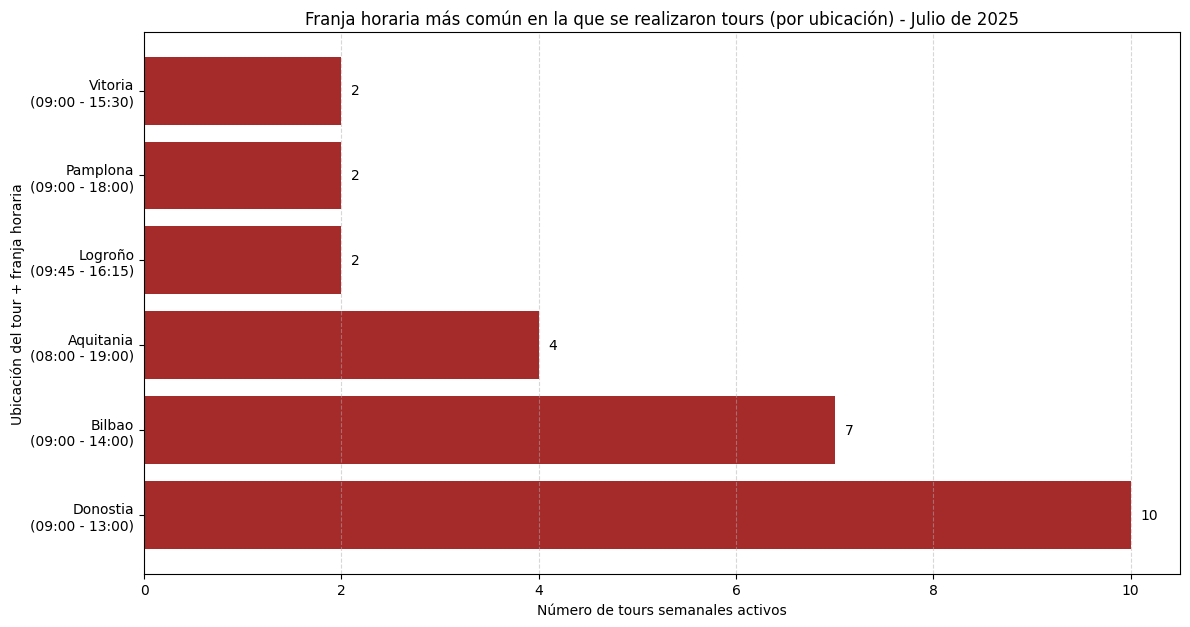

In [455]:
# --- INSIGHT 11.5: Most Common Time Slot per Location – July 2025 ---

# Construct TimeSlot string
tours_07_2025["TimeSlot"] = (
    tours_07_2025["TimeStart"].astype(str)
    + " - "
    + tours_07_2025["TimeEnd"].astype(str)
)

# Calculate operating days per tour
op_cols_07_2025 = [
    "Op_Monday",
    "Op_Tuesday",
    "Op_Wednesday",
    "Op_Thursday",
    "Op_Friday",
    "Op_Saturday",
    "Op_Sunday",
]
tours_07_2025["Tours_Operating_Days"] = tours_07_2025[op_cols_07_2025].sum(
    axis=1
)  # it tells how many days a tour actually runs

# Filter only active tours
active_tours_07_2025 = tours_07_2025[tours_07_2025["Tours_Operating_Days"] > 0]

# Count time slot per location
slot_counts_07_2025 = (
    active_tours_07_2025.groupby(["TourLocation", "TimeSlot"])
    .size()
    .reset_index(name="Count")
)

# Select the most common time slot per location
top_slot_07_2025 = slot_counts_07_2025.sort_values(
    "Count", ascending=False
).drop_duplicates(subset=["TourLocation"], keep="first")

# Label for plotting (Location + Time Slot)
top_slot_07_2025["Label"] = (
    top_slot_07_2025["TourLocation"] + "\n(" + top_slot_07_2025["TimeSlot"] + ")"
)

# Plot horizontal bar chart
plt.figure(figsize=DEFAULT_FIGSIZE)
bars = plt.barh(
    top_slot_07_2025["Label"], top_slot_07_2025["Count"], color=BAR_COLORS["07"]
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.1, y_pos, str(int(width)), va="center", fontsize=LABEL_FONT_SIZE)

# Styling
plt.xlabel("Número de tours semanales activos")
plt.ylabel("Ubicación del tour + franja horaria")
plt.title(
    f'Franja horaria más común en la que se realizaron tours (por ubicación) - {MONTHS["07"]}'
)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Layout adjustments
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.subplots_adjust(top=1.2)
plt.show()